In [3]:
pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 879.0/879.0 kB 6.2 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from scipy import stats

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import yfinance as yf

from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [4]:
# Ref: https://towardsdatascience.com/8-commonly-used-pandas-display-options-you-should-know-a832365efa95
# ADJUST COLUMN WIDTH IN PANDAS TO SHOW ALL TEXT
# (FOR MODEL PERFORMANCE DISPLAY LATER)

pd.set_option('display.max_colwidth', None)

In [5]:
# PRE-SET PATH TO images FOLDER TO SAVE PLOTS LATER
directory_to_img = os.path.join('..', '..', 'images')

In [7]:
#SET SEED FOR REPRODUCIBILITY
seed = 2021

In [8]:
# SELECT START AND END DATE
start = datetime(2014, 1, 1)
end = datetime(2021, 8, 31)


tckr = 'BTC-USD'

ticker = yf.Ticker(tckr)
df = ticker.history(start=start, 
                    end=end, 
                    interval="1d")

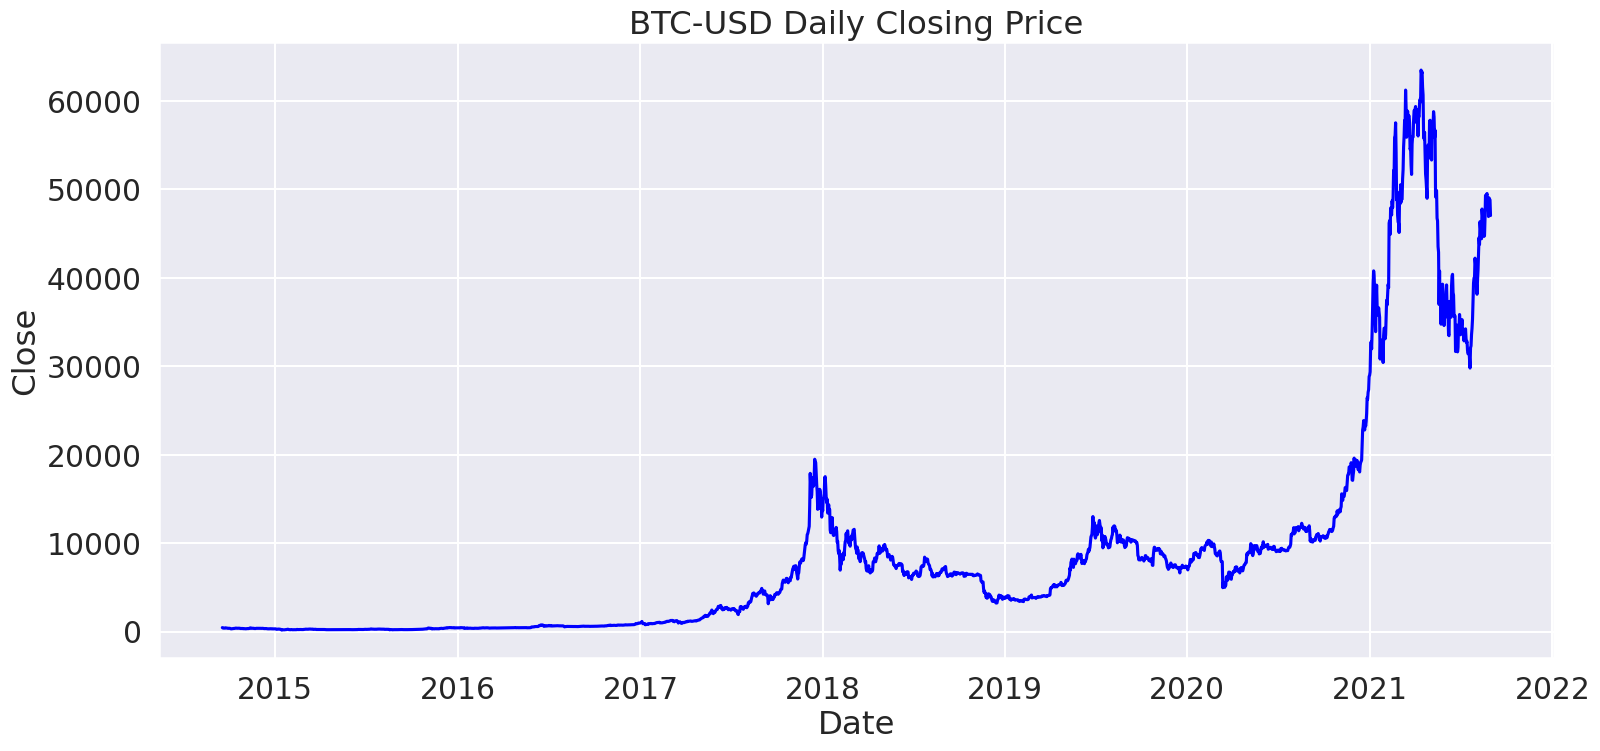

In [9]:
# CHANGE CONTEXT TO poster TO INCREASE FONT SIZES
sns.set_context("talk", font_scale=1.3)

# PLOT OUT BTC-USE'S CLOSING PRICES SINCE 2014
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(18,8))
    sns.lineplot(x=df.index, y=df.Close, color='blue')
    ax.set_title('BTC-USD Daily Closing Price')    


In [10]:
# CALCULATE PRICE RETURNS AS DAILY PERCENTAGE CHANGE USING pct_change()
df['returns'] = 100 * df.Close.pct_change().dropna()

In [11]:
# CALCULATE LOG RETURNS BASED ON ABOVE FORMULA
df['log_returns'] = np.log(df.Close/df.Close.shift(1))

In [12]:
df.head()

Open        High         Low       Close  \
Date                                                                        
2014-09-17 00:00:00+00:00  465.864014  468.174011  452.421997  457.334015   
2014-09-18 00:00:00+00:00  456.859985  456.859985  413.104004  424.440002   
2014-09-19 00:00:00+00:00  424.102997  427.834991  384.532013  394.795990   
2014-09-20 00:00:00+00:00  394.673004  423.295990  389.882996  408.903992   
2014-09-21 00:00:00+00:00  408.084991  412.425995  393.181000  398.821014   

                             Volume  Dividends  Stock Splits   returns  \
Date                                                                     
2014-09-17 00:00:00+00:00  21056800          0             0       NaN   
2014-09-18 00:00:00+00:00  34483200          0             0 -7.192558   
2014-09-19 00:00:00+00:00  37919700          0             0 -6.984265   
2014-09-20 00:00:00+00:00  36863600          0             0  3.573492   
2014-09-21 00:00:00+00:00  26580100          0             0 -2.465854   

                           log_returns  
Date                                    
2014-09-17 00:00:00+00:00          NaN  
2014-09-18 00:00:00+00:00    -0.074643  
2014-09-19 00:00:00+00:00    -0.072402  
2014-09-20 00:00:00+00:00     0.035111  
2014-09-21 00:00:00+00:00    -0.024968

In [13]:
# DROPPING THE 1ST ROW OF DATA 
# BECAUSE I SHIFTED IT FORWARD TO CALCULATE RETURNS/LOG RETURNS
df.dropna(inplace=True)


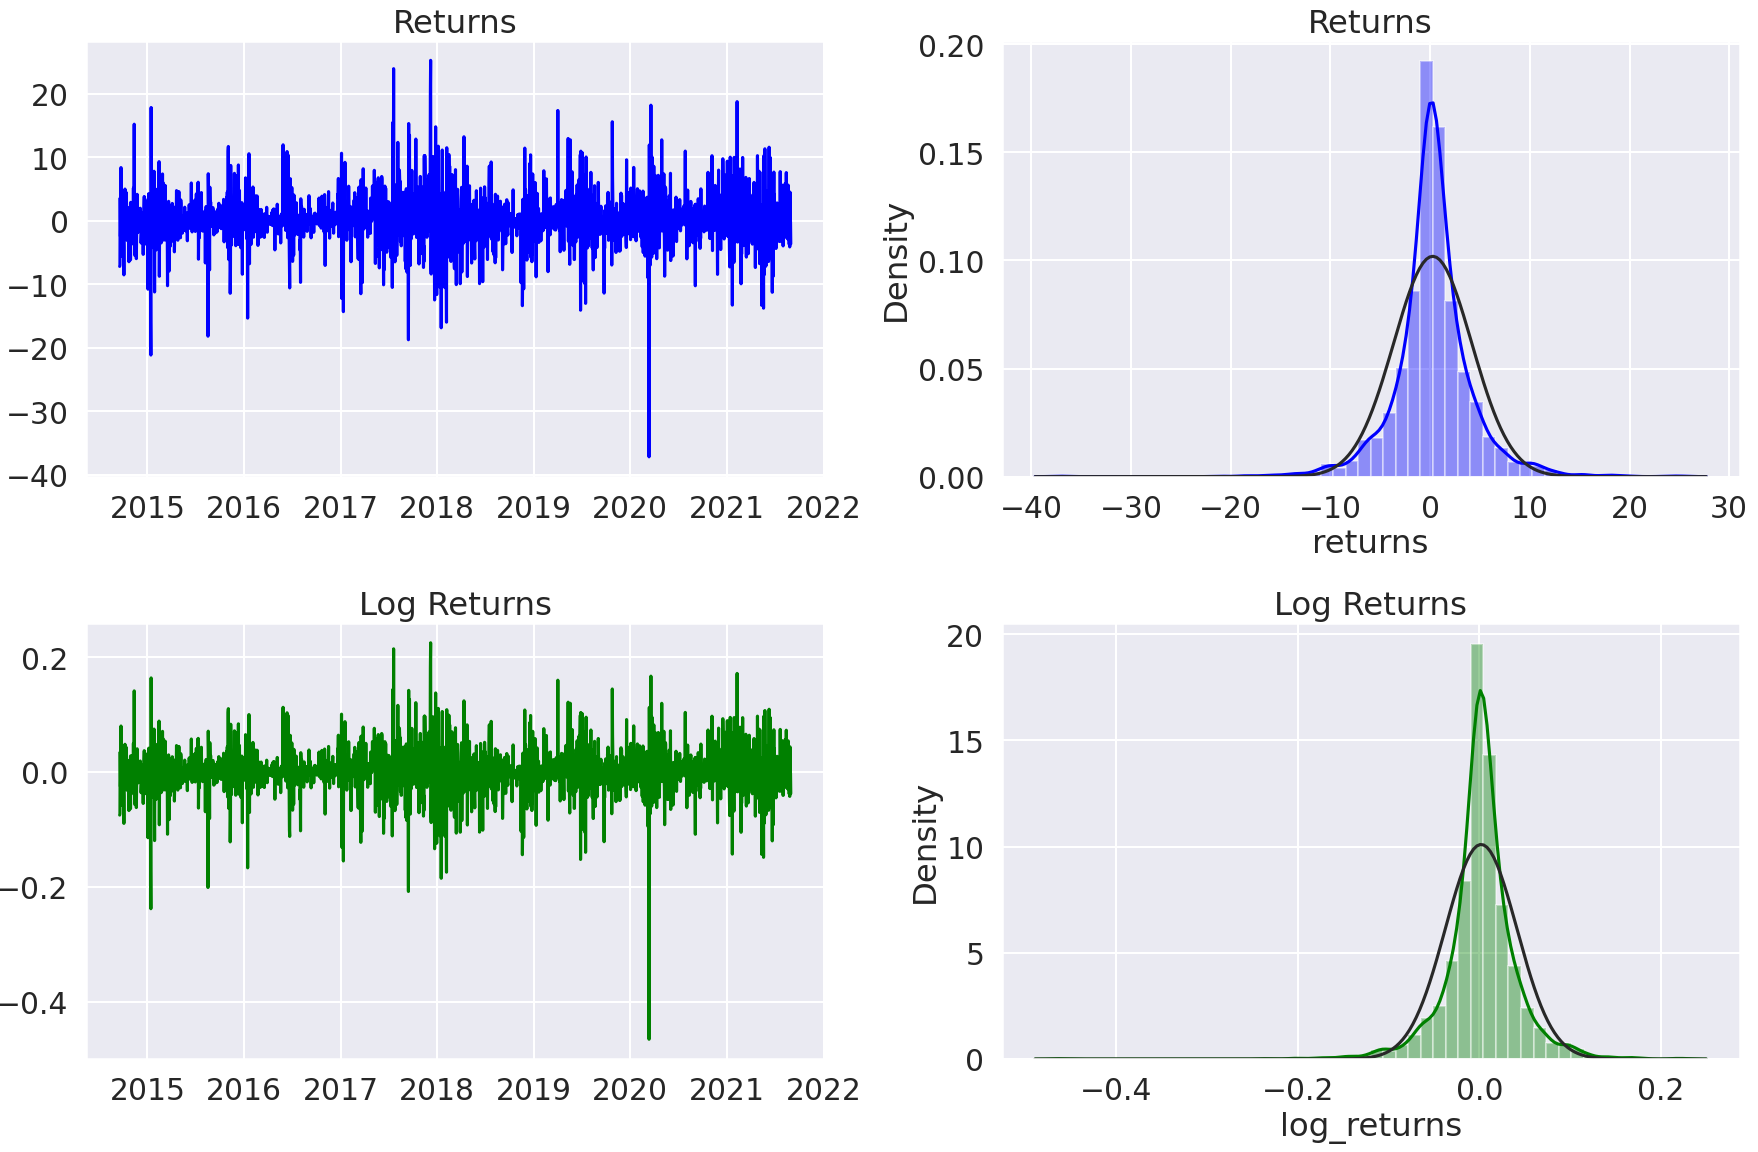

In [14]:
# PLOT DISTRIBUTION PLOTS OF RETURNS & LOG RETURNS
# AND VISUALLY COMPARE THEM WITH THE STANDARD NORMAL DISTRIBUTION
with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18,12))

    axes[0][0].plot(df.returns, color='blue')
    axes[0][0].set_title('Returns')

    sns.distplot(df.returns, norm_hist=True, fit=stats.norm, color='blue',
                bins=50, ax=axes[0][1])
    axes[0][1].set_title('Returns')

    axes[1][0].plot(df.log_returns, color='green')
    axes[1][0].set_title('Log Returns')

    sns.distplot(df.log_returns, norm_hist=True, fit=stats.norm, color='green',
                bins=50, ax=axes[1][1])
    axes[1][1].set_title('Log Returns')
    plt.tight_layout()
    fig.show();

In [15]:
df.returns.describe()

count    2539.000000
mean        0.260028
std         3.914642
min       -37.169539
25%        -1.280782
50%         0.199896
75%         1.825499
max        25.247169
Name: returns, dtype: float64

In [16]:
df.log_returns.describe()

count    2539.000000
mean        0.001825
std         0.039483
min        -0.464730
25%        -0.012891
50%         0.001997
75%         0.018090
max         0.225119
Name: log_returns, dtype: float64

In [17]:
# CREATE A FUNCTION THAT CALCULATE REALIZED VOLATILITY
# FROM SAILY LOG RETURNS
def realized_volatility_daily(series_log_return):
    """
    Get the daily realized volatility which is calculated as the square root
    of sum of squares of log returns within a specific window interval 
    """
    n = len(series_log_return)
    return np.sqrt(np.sum(series_log_return**2)/(n - 1))

In [20]:
intervals = [7, 30]
vols_df = {}

# ITERATE OVER intervals LIST
for i in intervals:
    # GET DAILY LOG RETURNS USING THAT INTERVAL
    vols = df.log_returns.rolling(window=i)\
                         .apply(realized_volatility_daily).values

    vols_df[i] = vols

# CONVERT vols_df FROM DICTIONARY TO PANDAS DATAFRAME
vols_df = pd.DataFrame(vols_df, columns=intervals, index=df.index)

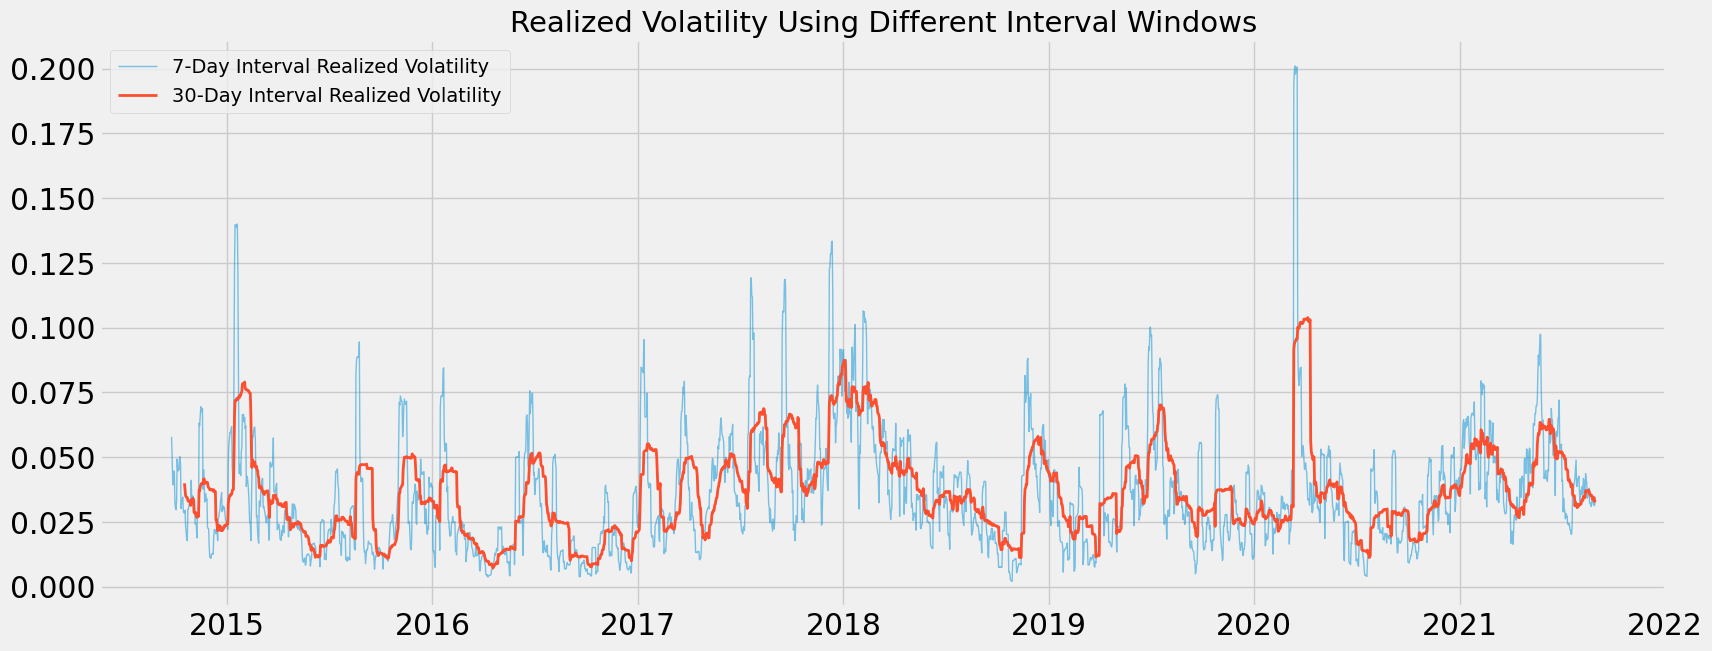

In [21]:
# CHANGING MATPLOTLIB STYLE
plt.style.use(['fivethirtyeight'])

fig, ax = plt.subplots(figsize=(18,7))

for i in intervals:
    if i == 7:
        alpha = 0.5
        lw = 1
    else:
        alpha = 1.0
        lw = 2
    ax.plot(vols_df[i], label=f'{i}-Day Interval Realized Volatility', 
            alpha=alpha, lw=lw)

ax.set_title('Realized Volatility Using Different Interval Windows', fontsize=21)

plt.legend(loc='best', prop={'size': 14})
plt.show();

In [22]:
INTERVAL_WINDOW = 30
n_future = 7

# GET BACKWARD LOOKING REALIZED VOLATILITY
df['vol_current'] = df.log_returns.rolling(window=INTERVAL_WINDOW)\
                                   .apply(realized_volatility_daily)

# GET FORWARD LOOKING REALIZED VOLATILITY 
df['vol_future'] = df.log_returns.shift(-n_future)\
                                 .rolling(window=INTERVAL_WINDOW)\
                                 .apply(realized_volatility_daily)

In [23]:
df.describe()

Open          High           Low         Close        Volume  \
count   2539.000000   2539.000000   2539.000000   2539.000000  2.539000e+03   
mean    8681.166269   8929.541857   8411.818657   8699.331872  1.348326e+10   
std    12796.869340  13191.400463  12347.219811  12818.326001  1.996122e+10   
min      176.897003    211.731003    171.509995    178.102997  5.914570e+06   
25%      574.092499    578.319000    568.903992    574.212494  7.275385e+07   
50%     5204.105469   5319.986328   5055.194824   5210.515625  4.333440e+09   
75%     9511.579102   9682.253906   9302.726074   9514.672852  2.120531e+10   
max    63523.753906  64863.097656  62208.964844  63503.457031  3.509679e+11   

       Dividends  Stock Splits      returns  log_returns  vol_current  \
count     2539.0        2539.0  2539.000000  2539.000000  2510.000000   
mean         0.0           0.0     0.260028     0.001825     0.036331   
std          0.0           0.0     3.914642     0.039483     0.017227   
min          0.0           0.0   -37.169539    -0.464730     0.007228   
25%          0.0           0.0    -1.280782    -0.012891     0.024471   
50%          0.0           0.0     0.199896     0.001997     0.034003   
75%          0.0           0.0     1.825499     0.018090     0.046009   
max          0.0           0.0    25.247169     0.225119     0.103878   

        vol_future  
count  2503.000000  
mean      0.036333  
std       0.017251  
min       0.007228  
25%       0.024461  
50%       0.033911  
75%       0.046032  
max       0.103878

In [24]:
df = df.drop(['Dividends', 'Stock Splits'], axis=1)

In [25]:
df.describe()


Open          High           Low         Close        Volume  \
count   2539.000000   2539.000000   2539.000000   2539.000000  2.539000e+03   
mean    8681.166269   8929.541857   8411.818657   8699.331872  1.348326e+10   
std    12796.869340  13191.400463  12347.219811  12818.326001  1.996122e+10   
min      176.897003    211.731003    171.509995    178.102997  5.914570e+06   
25%      574.092499    578.319000    568.903992    574.212494  7.275385e+07   
50%     5204.105469   5319.986328   5055.194824   5210.515625  4.333440e+09   
75%     9511.579102   9682.253906   9302.726074   9514.672852  2.120531e+10   
max    63523.753906  64863.097656  62208.964844  63503.457031  3.509679e+11   

           returns  log_returns  vol_current   vol_future  
count  2539.000000  2539.000000  2510.000000  2503.000000  
mean      0.260028     0.001825     0.036331     0.036333  
std       3.914642     0.039483     0.017227     0.017251  
min     -37.169539    -0.464730     0.007228     0.007228  
25%      -1.280782    -0.012891     0.024471     0.024461  
50%       0.199896     0.001997     0.034003     0.033911  
75%       1.825499     0.018090     0.046009     0.046032  
max      25.247169     0.225119     0.103878     0.103878

In [26]:
# DROPPING ALL NaN VALUES
df.dropna(inplace=True)

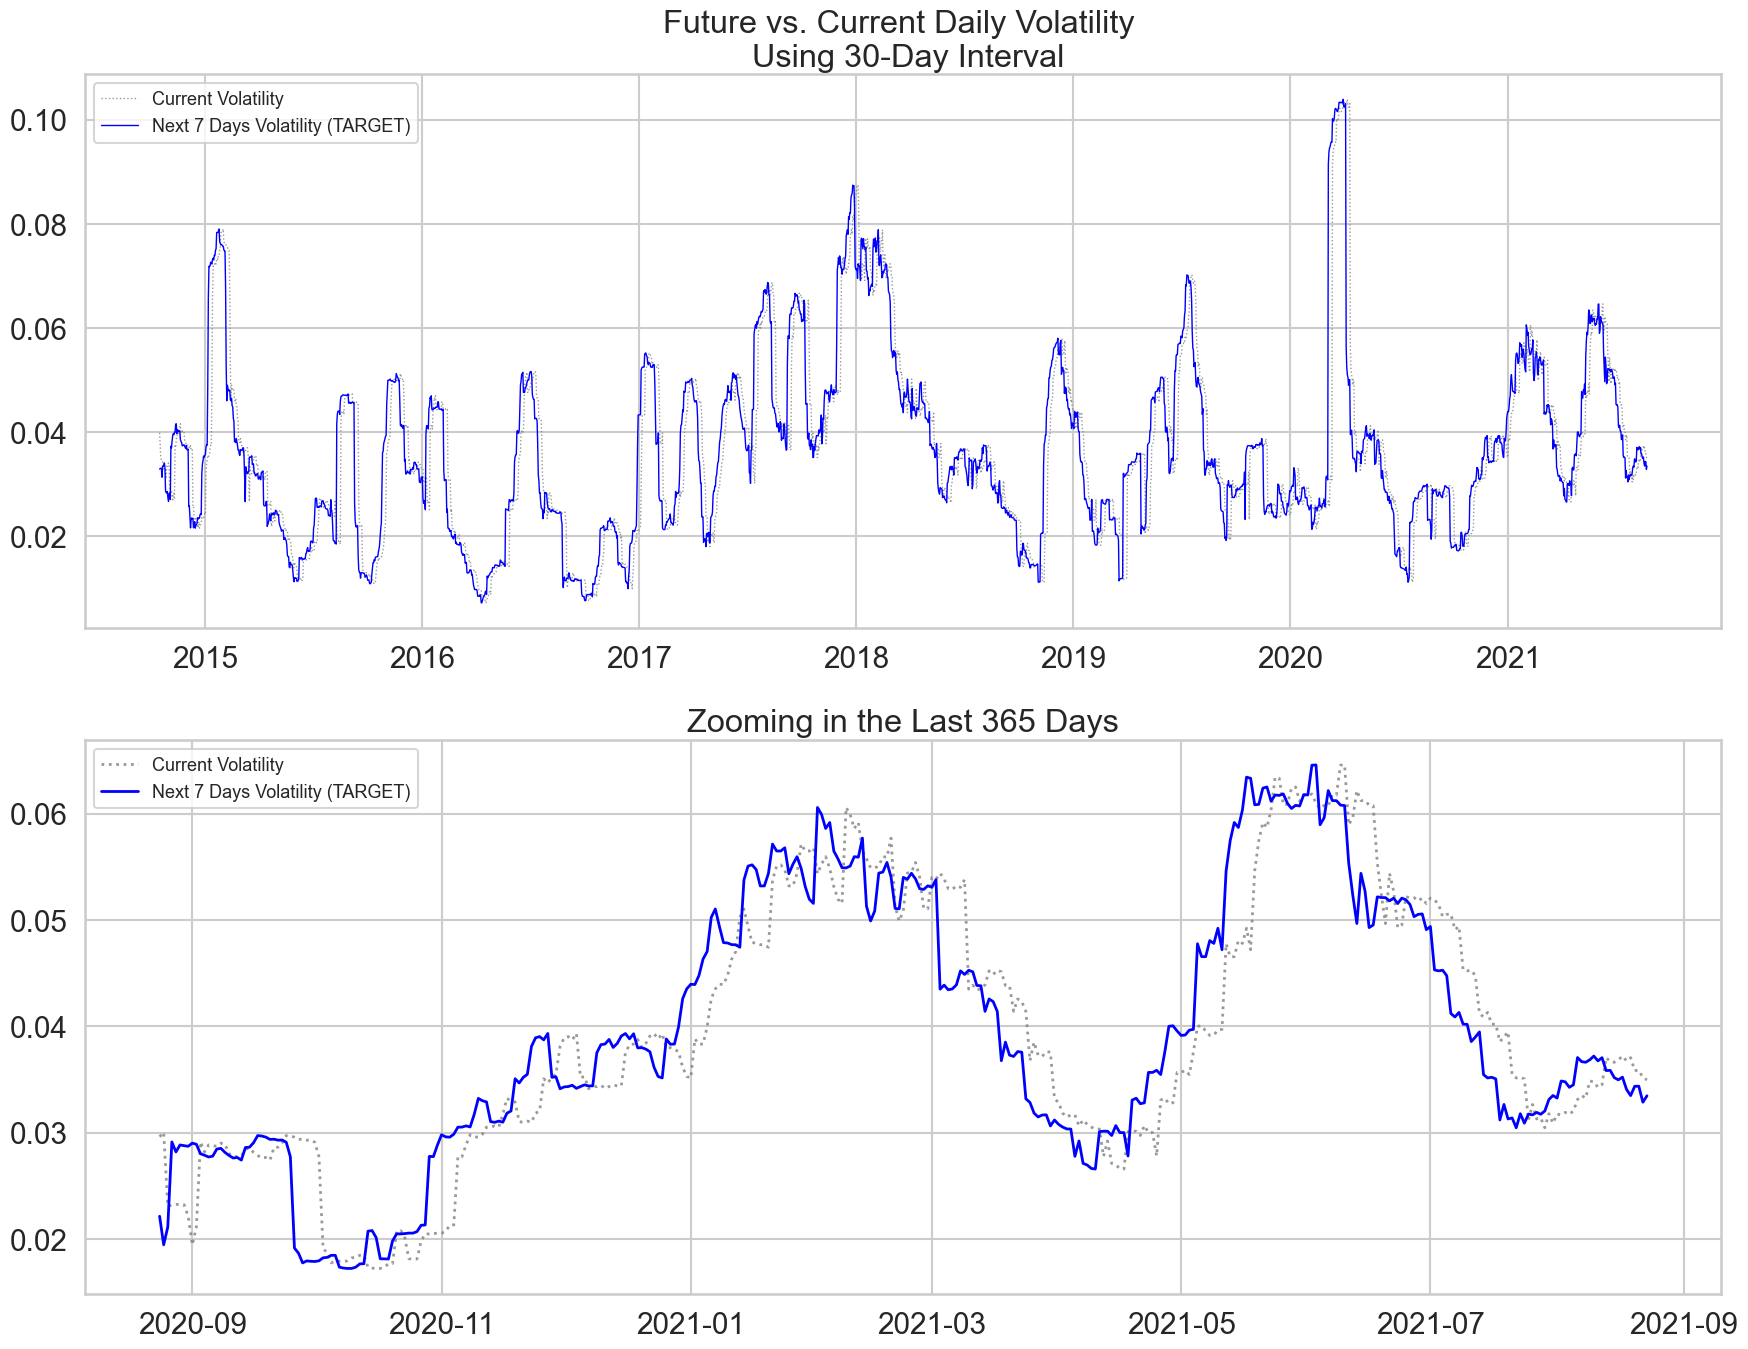

In [27]:
n_zoom = 365
sns.set_context("talk", font_scale=1.3)
# plt.style.use(['seaborn'])

# VISUALIZE REALIZED CURRENT VS. FUTURE VOLATILITY
with sns.axes_style("whitegrid"):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(18,14))

    ax1.plot(df.vol_current, alpha=.8, lw=1, color='gray', ls=':',
            label='Current Volatility')
    ax1.plot(df.vol_future, lw=1, color='blue',
            label=f'Next {n_future} Days Volatility (TARGET)')

    ax2.plot(df.vol_current[-n_zoom:], alpha=.8, lw=2, color='gray', ls=':',
            label='Current Volatility')
    ax2.plot(df.vol_future[-n_zoom:], lw=2, color='blue',
            label=f'Next {n_future} Days Volatility (TARGET)')

    ax1.title.set_text(f'Future vs. Current Daily Volatility \n Using {INTERVAL_WINDOW}-Day Interval')
    ax2.title.set_text(f'Zooming in the Last {n_zoom} Days')

    ax1.legend(loc='upper left', prop={'size': 13}, frameon=True)
    ax2.legend(loc='upper left', prop={'size': 13}, frameon=True)
    plt.tight_layout()
    plt.show();

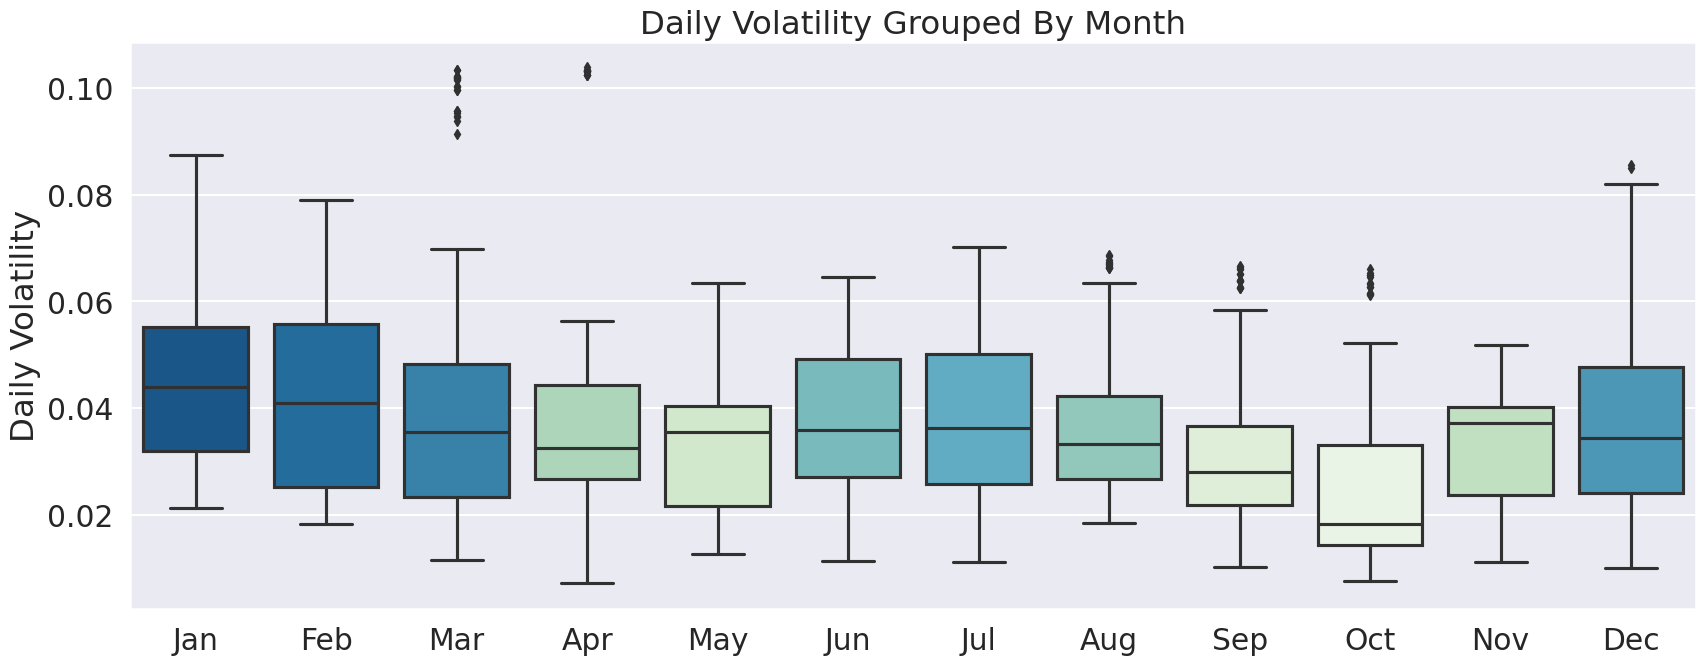

In [28]:
# PRESORT MONTHS IN CHRONOLOGICAL ORDER 
ordered_months = ['Jan', 'Feb', 'Mar', 'Apr','May','Jun', 
                  'Jul', 'Aug','Sep', 'Oct', 'Nov', 'Dec']

# GROUP vol_current BY MONTH AND TAKE THE MEAN
data = df.groupby(by=[df.index.month_name()]).vol_current.mean()

# ABBREVIATE MONTH NAME
data.index = [x[:3] for x in data.index]

# SELECT PALETTE
pal = sns.color_palette("GnBu", len(data))

# SORT MONTH BY AVERAGE vol_current
rank = data.argsort().argsort().reindex(ordered_months)

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(18,7))
    
    sns.boxplot(x=[x[:3] for x in df.index.month_name()], 
                y=df.vol_current, 
                palette=np.array(pal)[rank],
                order=ordered_months)
    ax.set(xlabel='', 
           ylabel='Daily Volatility', 
           title='Daily Volatility Grouped By Month')

In [29]:
df.vol_current.sort_values(ascending=False)[:50]

Date
2020-04-06 00:00:00+00:00    0.103878
2020-04-03 00:00:00+00:00    0.103330
2020-04-02 00:00:00+00:00    0.103319
2020-03-30 00:00:00+00:00    0.103302
2020-03-31 00:00:00+00:00    0.103300
2020-04-01 00:00:00+00:00    0.103203
2020-04-05 00:00:00+00:00    0.103192
2020-04-04 00:00:00+00:00    0.103175
2020-04-10 00:00:00+00:00    0.103052
2020-04-07 00:00:00+00:00    0.102421
2020-04-09 00:00:00+00:00    0.102414
2020-04-08 00:00:00+00:00    0.102411
2020-03-29 00:00:00+00:00    0.102179
2020-03-24 00:00:00+00:00    0.102140
2020-03-25 00:00:00+00:00    0.102018
2020-03-23 00:00:00+00:00    0.101864
2020-03-26 00:00:00+00:00    0.101844
2020-03-28 00:00:00+00:00    0.101738
2020-03-27 00:00:00+00:00    0.101523
2020-03-22 00:00:00+00:00    0.100300
2020-03-19 00:00:00+00:00    0.100166
2020-03-20 00:00:00+00:00    0.099710
2020-03-21 00:00:00+00:00    0.099709
2020-03-17 00:00:00+00:00    0.095724
2020-03-18 00:00:00+00:00    0.095614
2020-03-16 00:00:00+00:00    0.095421
2020-03

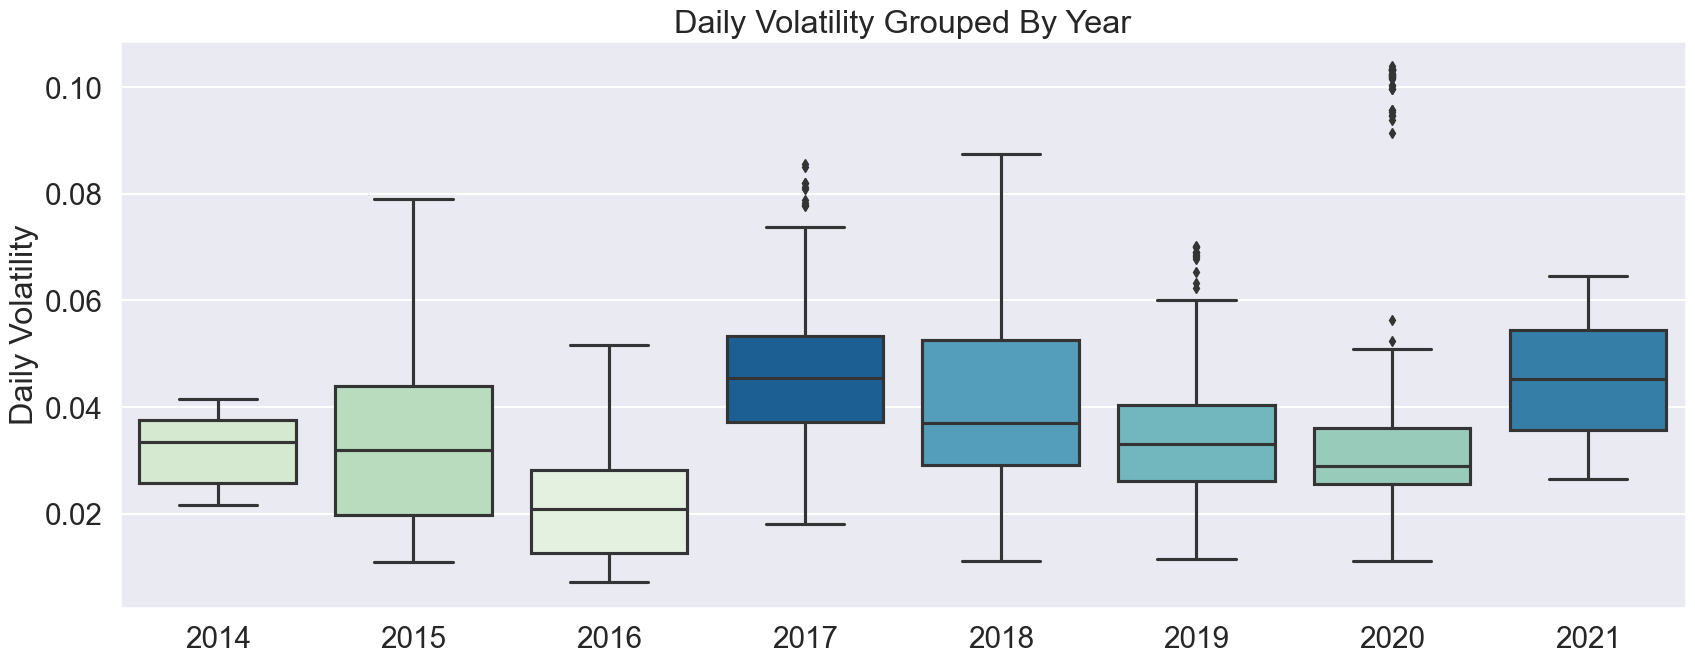

In [30]:
# GROUP vol_current BY YEAR AND TAKE THE MEAN
data = df.groupby(by=[df.index.year]).vol_current.mean()

# SELECT PALETTE
pal = sns.color_palette("GnBu", len(data))

# SORT MONTH BY AVERAGE vol_current
rank = data.argsort().argsort()

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(18,7))
    
    sns.boxplot(x=df.index.year, 
                y=df.vol_current, 
                palette=np.array(pal)[rank])
    ax.set(xlabel='', 
           ylabel='Daily Volatility', 
           title='Daily Volatility Grouped By Year')
    plt.show()

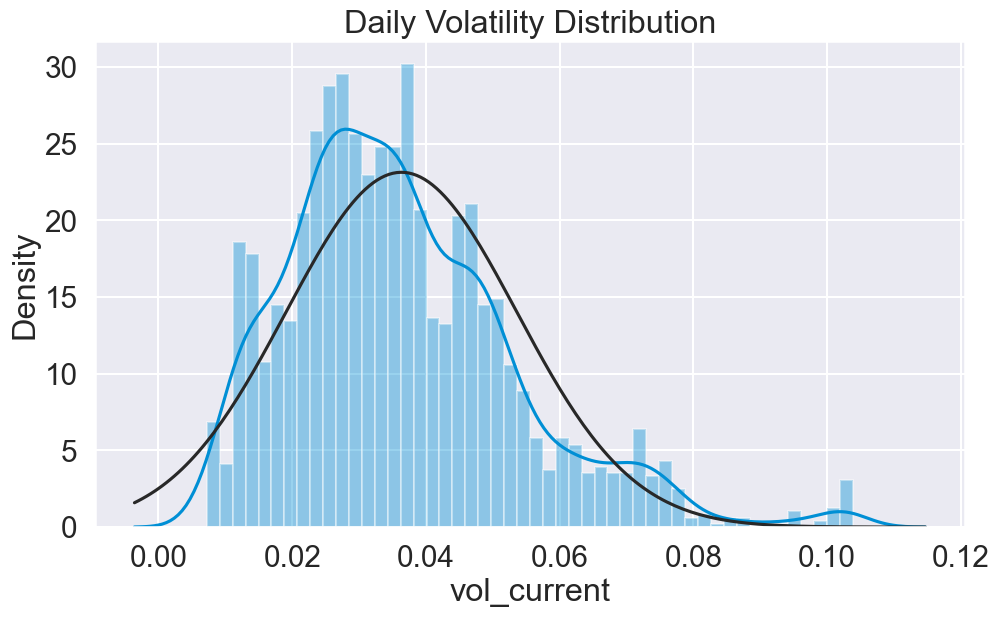

In [31]:
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(10,6))
    sns.distplot(df.vol_current, norm_hist=True, fit=stats.norm,
                bins=50, ax=ax)
    plt.title('Daily Volatility Distribution')
    plt.show();

In [32]:
from statsmodels.tsa.stattools import adfuller

In [33]:
# LOG RETURNS
adfuller_results = adfuller(df.log_returns.dropna())

print(f'ADF Statistic: {adfuller_results[0]}')
print(f'p-value: {adfuller_results[1]}')
print('Critical Values:')
for key, value in adfuller_results[4].items():
    print(f'{key}: {value:.4f}')

ADF Statistic: -15.0712040445357
p-value: 8.719632644593038e-28
Critical Values:
1%: -3.4330
5%: -2.8627
10%: -2.5674


In [34]:
# RETURNS
adfuller_results = adfuller(df.returns.dropna())

print(f'ADF Statistic: {adfuller_results[0]}')
print(f'p-value: {adfuller_results[1]}')
print('Critical Values:')
for key, value in adfuller_results[4].items():
    print(f'{key}: {value:.4f}')

ADF Statistic: -15.02310828924831
p-value: 1.0155301109877661e-27
Critical Values:
1%: -3.4330
5%: -2.8627
10%: -2.5674


In [35]:
# PRE-DETERMINE DESIRED TEST & VALIDATION SIZES
test_size = 30
val_size = 365

# CONVERT TO INDICES
split_time_1 = len(df) - (val_size + test_size)
split_time_2 = len(df) - test_size

# GET CORRESPONDING DATETIME INDICES FOR EACH SET
train_idx = df.index[:split_time_1]
val_idx = df.index[split_time_1:split_time_2]
test_idx = df.index[split_time_2:]

In [36]:
print(f'TRAINING \tFrom: {train_idx[0]} \tto: {train_idx[-1]} \t{len(train_idx)} days')
print(f'VALIDATION \tFrom: {val_idx[0]} \tto: {val_idx[-1]} \t{len(val_idx)} days')
print(f'TEST \t\tFrom: {test_idx[0]} \tto: {test_idx[-1]} \t{len(test_idx)} days')

TRAINING 	From: 2014-10-17 00:00:00+00:00 	to: 2020-07-24 00:00:00+00:00 	2108 days
VALIDATION 	From: 2020-07-25 00:00:00+00:00 	to: 2021-07-24 00:00:00+00:00 	365 days
TEST 		From: 2021-07-25 00:00:00+00:00 	to: 2021-08-23 00:00:00+00:00 	30 days


In [37]:
# SPLIT FORWARD VOLATILITY INTO 3 PARTS 
# (this would be the target)
y_train = df.vol_future[train_idx]
y_val = df.vol_future[val_idx]
y_test = df.vol_future[test_idx]

In [38]:
# SPLIT CURRENT DAILY REALIZED VOLATILITY INTO 3 PARTS 
# (this would be the input for baseline, random walk, and NN models)
x_train = df.vol_current[train_idx]
x_val = df.vol_current[val_idx]
x_test = df.vol_current[test_idx]

In [39]:
# SPLIT RETURNS INTO 3 PARTS
# (this would be the input for GARCH models)
r_train = df.returns[train_idx]
r_val = df.returns[val_idx]
r_test = df.returns[test_idx]


In [40]:
# SPLIT LOG RETURNS INTO 3 PARTS
# (mostly for visualization)
lr_train = df.log_returns[train_idx]
lr_val = df.log_returns[val_idx]
lr_test = df.log_returns[test_idx]

In [41]:
y_train.describe()

count    2108.000000
mean        0.035915
std         0.018005
min         0.007228
25%         0.023500
50%         0.033271
75%         0.045736
max         0.103878
Name: vol_future, dtype: float64

In [42]:
x_train.describe()

count    2108.000000
mean        0.035968
std         0.017978
min         0.007228
25%         0.023549
50%         0.033433
75%         0.045736
max         0.103878
Name: vol_current, dtype: float64

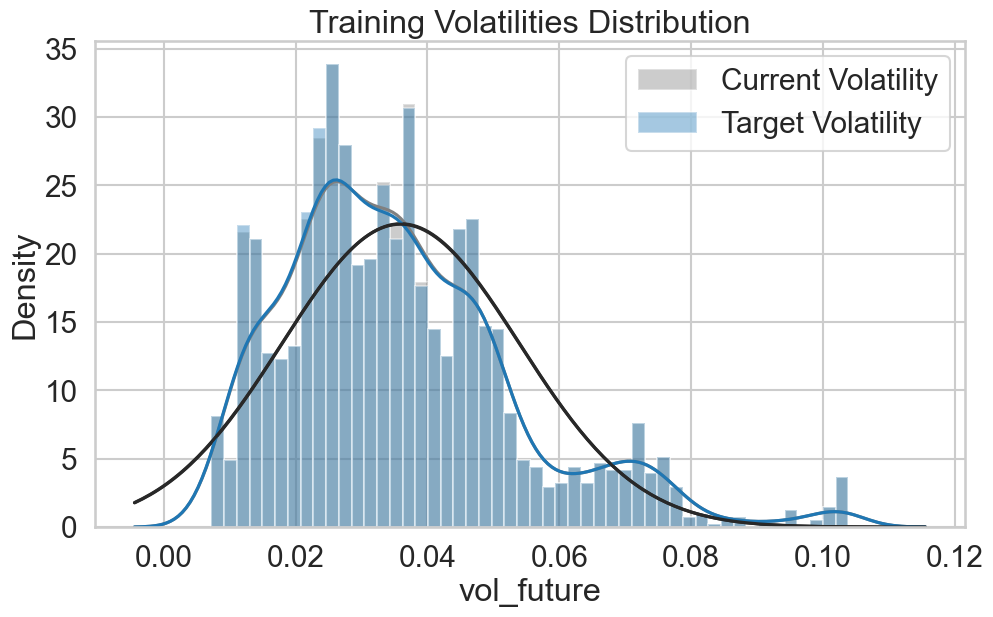

In [43]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(10,6))
    sns.distplot(x_train, norm_hist=True, fit=stats.norm, 
                 color='gray', 
                 bins=50, ax=ax, label='Current Volatility')
    sns.distplot(y_train, norm_hist=True, fit=stats.norm,
                 color='tab:blue', 
                 bins=50, ax=ax, label='Target Volatility')
    plt.title('Training Volatilities Distribution')
    plt.legend()
    plt.show();


In [44]:
def transform_volatility_to_scaler(scaler, tf_series):
    '''
    Transform a series to a fitted scaler
    '''
    idx = tf_series.index
    output = pd.Series(scaler.transform(tf_series.values.reshape(-1,1))[:,0],
                       index=idx)
    return output

In [45]:
# INITIATE SCALER
scaler_vol = MinMaxScaler()

# FIT SCALER TO CURRENT VOLATILITY IN TRAINING SET
scaler_vol = scaler_vol.fit(x_train.values.reshape(-1,1))

In [46]:
# TRANSFORM TRAINING CURRENT & FUTURE VOLATILITIES 
x_train_scaled = transform_volatility_to_scaler(scaler_vol, x_train)
y_train_scaled = transform_volatility_to_scaler(scaler_vol, y_train)

# TRANSFORMING VALIDATION CURRENT & FUTURE VOLATILITIES
x_val_scaled = transform_volatility_to_scaler(scaler_vol, x_val)
y_val_scaled = transform_volatility_to_scaler(scaler_vol, y_val)

# TRANSFORMING TEST CURRENT & FUTURE VOLATILITIES
x_test_scaled = transform_volatility_to_scaler(scaler_vol, x_test)
y_test_scaled = transform_volatility_to_scaler(scaler_vol, y_test)

In [47]:
x_train.head(10)

Date
2014-10-17 00:00:00+00:00    0.039872
2014-10-18 00:00:00+00:00    0.037566
2014-10-19 00:00:00+00:00    0.035089
2014-10-20 00:00:00+00:00    0.034629
2014-10-21 00:00:00+00:00    0.034362
2014-10-22 00:00:00+00:00    0.034364
2014-10-23 00:00:00+00:00    0.033347
2014-10-24 00:00:00+00:00    0.032900
2014-10-25 00:00:00+00:00    0.033009
2014-10-26 00:00:00+00:00    0.033083
Name: vol_current, dtype: float64

In [48]:
y_train.head(10)

Date
2014-10-17 00:00:00+00:00    0.032900
2014-10-18 00:00:00+00:00    0.033009
2014-10-19 00:00:00+00:00    0.033083
2014-10-20 00:00:00+00:00    0.033017
2014-10-21 00:00:00+00:00    0.031334
2014-10-22 00:00:00+00:00    0.033474
2014-10-23 00:00:00+00:00    0.033426
2014-10-24 00:00:00+00:00    0.033602
2014-10-25 00:00:00+00:00    0.034075
2014-10-26 00:00:00+00:00    0.033154
Name: vol_future, dtype: float64

In [49]:
x_train_scaled.head(10)

Date
2014-10-17 00:00:00+00:00    0.337754
2014-10-18 00:00:00+00:00    0.313894
2014-10-19 00:00:00+00:00    0.288269
2014-10-20 00:00:00+00:00    0.283501
2014-10-21 00:00:00+00:00    0.280738
2014-10-22 00:00:00+00:00    0.280764
2014-10-23 00:00:00+00:00    0.270238
2014-10-24 00:00:00+00:00    0.265613
2014-10-25 00:00:00+00:00    0.266743
2014-10-26 00:00:00+00:00    0.267507
dtype: float64

In [50]:
y_train_scaled.head(10)

Date
2014-10-17 00:00:00+00:00    0.265613
2014-10-18 00:00:00+00:00    0.266743
2014-10-19 00:00:00+00:00    0.267507
2014-10-20 00:00:00+00:00    0.266830
2014-10-21 00:00:00+00:00    0.249415
2014-10-22 00:00:00+00:00    0.271550
2014-10-23 00:00:00+00:00    0.271058
2014-10-24 00:00:00+00:00    0.272883
2014-10-25 00:00:00+00:00    0.277768
2014-10-26 00:00:00+00:00    0.268242
dtype: float64

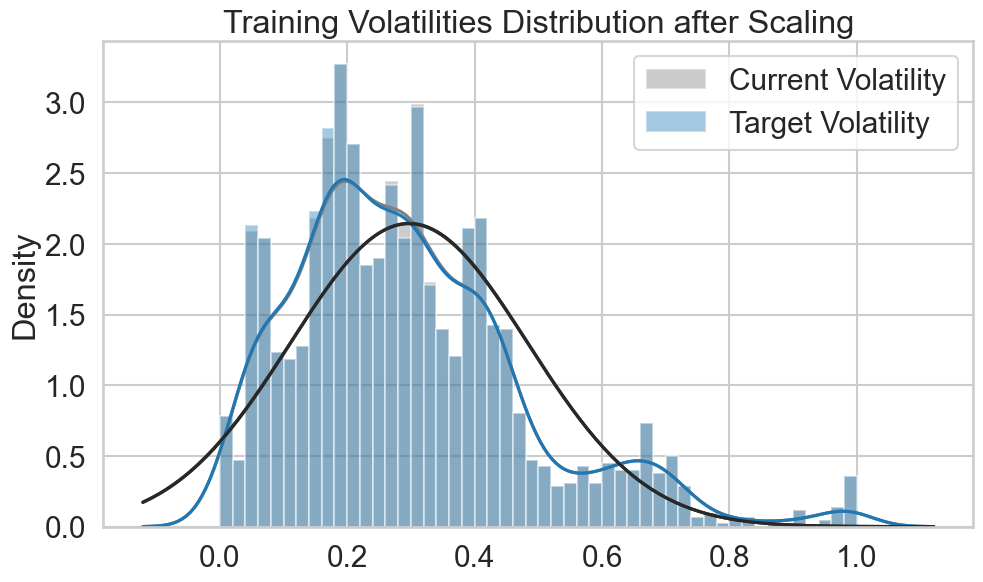

In [52]:
# PLOTTING VOLATILITIES AFTER SCALING
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(10,6))
    sns.distplot(x_train_scaled, norm_hist=True, fit=stats.norm, 
                 color='gray', 
                 bins=50, ax=ax, label='Current Volatility')
    sns.distplot(y_train_scaled, norm_hist=True, fit=stats.norm,
                 color='tab:blue', 
                 bins=50, ax=ax, label='Target Volatility')
    plt.title('Training Volatilities Distribution after Scaling')
    plt.legend()
    plt.show();

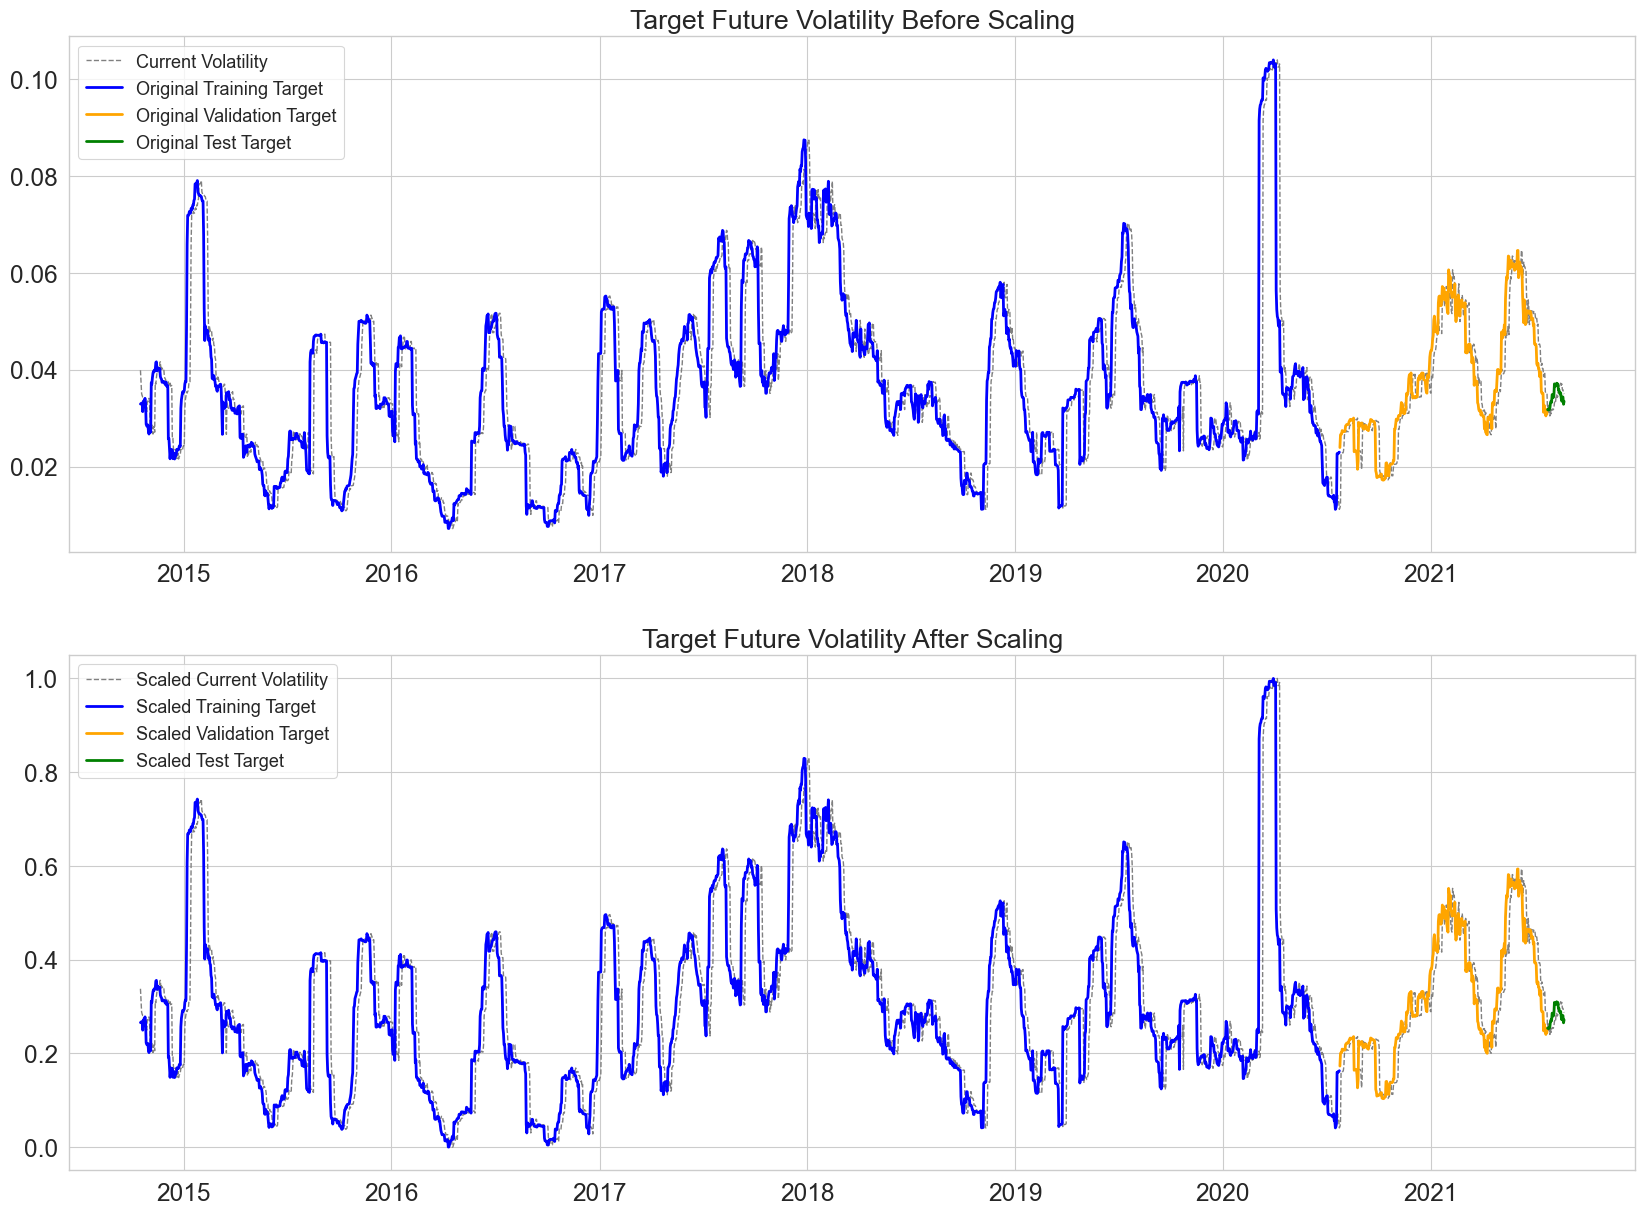

In [53]:
sns.set_context("paper", font_scale=2)

# VISUALIZE TRAIN/VALIDATION/TEST vol_future BEFORE & AFTER TRAINING
with sns.axes_style("whitegrid"):
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(18,14))

    ax1.plot(df.vol_current, lw=1, color='gray', ls='--',
                label='Current Volatility')
    ax1.plot(y_train, color='blue', label='Original Training Target', lw=2)
    ax1.plot(y_val, color='orange', label='Original Validation Target', lw=2)
    ax1.plot(y_test, color='green', label='Original Test Target', lw=2)

    ax1.title.set_text('Target Future Volatility Before Scaling')

    ax2.plot(transform_volatility_to_scaler(scaler_vol, df.vol_current), 
                lw=1, color='gray', ls='--',
                label='Scaled Current Volatility')
    ax2.plot(y_train_scaled, color='blue', label='Scaled Training Target', lw=2)
    ax2.plot(y_val_scaled, color='orange', label='Scaled Validation Target', lw=2)
    ax2.plot(y_test_scaled, color='green', label='Scaled Test Target', lw=2)

    ax2.title.set_text('Target Future Volatility After Scaling')

    ax1.legend(loc='upper left', prop={'size': 13}, frameon=True)
    ax2.legend(loc='upper left', prop={'size': 13}, frameon=True)
    plt.show()

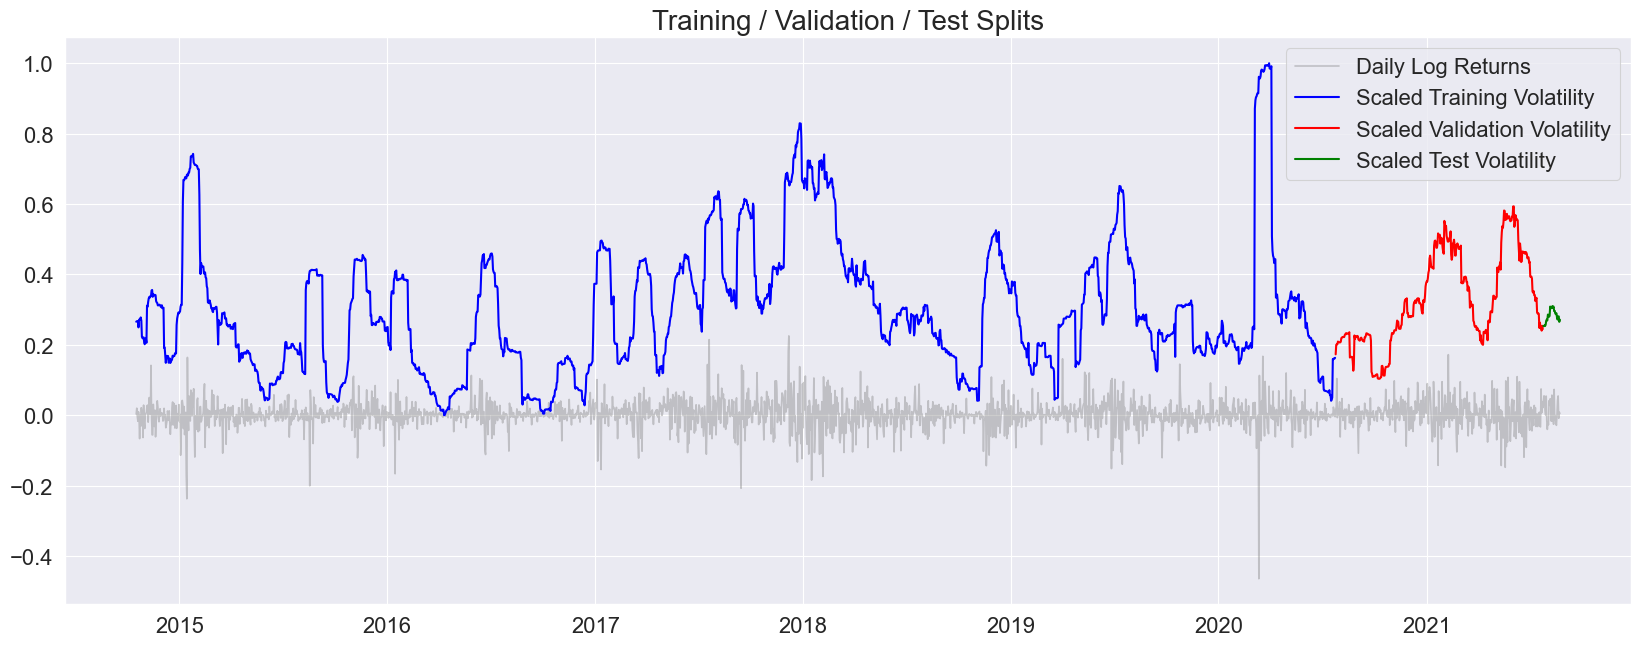

In [54]:
sns.set_context("paper", font_scale=1.8)
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(18,7))

    plt.plot(df.log_returns, color='gray', label='Daily Log Returns', alpha=0.4)

    plt.plot(y_train_scaled, color='blue', 
             label='Scaled Training Volatility', lw=1.5)
    plt.plot(y_val_scaled, color='red', 
             label='Scaled Validation Volatility', lw=1.5)
    plt.plot(y_test_scaled, color='green', 
             label='Scaled Test Volatility', lw=1.5)

    plt.plot()
    plt.title('Training / Validation / Test Splits', fontsize=20)
    plt.legend(frameon=True)
    plt.show();

In [55]:
# DEFINE ROOT MEAN SQUARED PERCENTAGE ERROR FUNCTION
def RMSPE(y_true, y_pred):
    """
    Compute Root Mean Squared Percentage Error between 2 arrays
    """
    output = np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))
    return output

In [56]:
# DEFINE ROOT MEAN SQUARED ERROR FUNCTION
def RMSE(y_true, y_pred):
    """
    Compute Root Mean Squared Error between 2 arrays
    """
    output = np.sqrt(mse(y_true, y_pred))
    return output

In [57]:
# INITIATE A DATAFRAME FOR MODEL PERFORMANCE TRACKING & COMPARISON 
perf_df = pd.DataFrame(columns=['Model', 'Validation RMSPE', 'Validation RMSE'])

In [58]:
# A FUNCTION THAT LOGS MODEL NAME, RMSE AND RMPSE INTO perf_df
# FOR EASY COMPARISON LATER
def log_perf(y_true, y_pred, model_name):
    perf_df.loc[len(perf_df.index)] = [model_name, 
                                       RMSPE(y_true, y_pred), 
                                       RMSE(y_true, y_pred)]
    return perf_df

In [59]:
# PLOTTING MODEL PREDICTIONS VS. TARGET VALUES
def viz_model(y_true, y_pred, model_name):
    sns.set_context("paper", font_scale=1.7)
    plt.rcParams["axes.grid"] = False

    with sns.axes_style("whitegrid"):
        plt.figure(figsize=(18,7))
        plt.plot(x_val_scaled, color='gray',  ls=':',
                label=f"Scaled Current Daily Volatility")
        
        plt.plot(y_true, color='blue', lw=2, 
                label=f"Target Volatility")
        plt.plot(y_pred, color='orange', lw=2.5,
                label=f'Forecasted Volatility')
        
        # plt.plot(lr_val, color='gray', alpha=0.4,
        #         label='Daily Log Returns')

        plt.title(f'{model_name} \non Validation Data')
        plt.legend(loc='best', frameon=True)

In [60]:
# CALCULATE THE MEAN OF SCALED TRAINING DATA
mean_train_vol = x_train_scaled.mean()
mean_train_vol

0.29735565847624096

In [61]:
# CREATE SERIES OF PREDICTIONS FOR BASELINE MODEL ON VALIDATION SET
baseline_preds = np.ones(len(val_idx)) * mean_train_vol
baseline_preds = pd.Series(baseline_preds, index=lr_val.index)

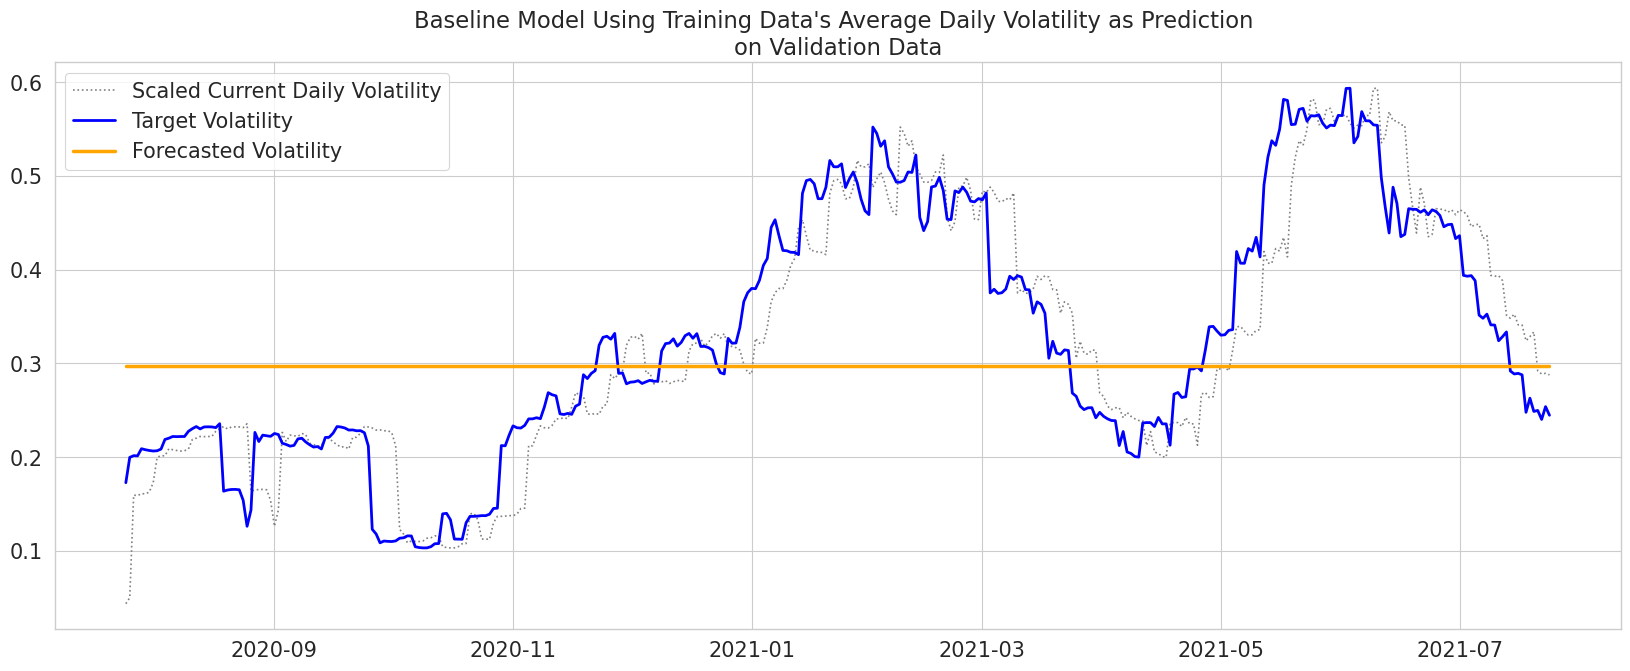

In [62]:
viz_model(y_val_scaled, baseline_preds, 
          f"Baseline Model Using Training Data's Average Daily Volatility as Prediction")
plt.show();

In [63]:
log_perf(y_val_scaled, baseline_preds, 'Mean Baseline')

Model  Validation RMSPE  Validation RMSE
0  Mean Baseline          0.559567         0.134522

In [64]:
# USING THE PREVIOUS n_future DAY'S VOLATILITY
random_walk_preds = x_val_scaled

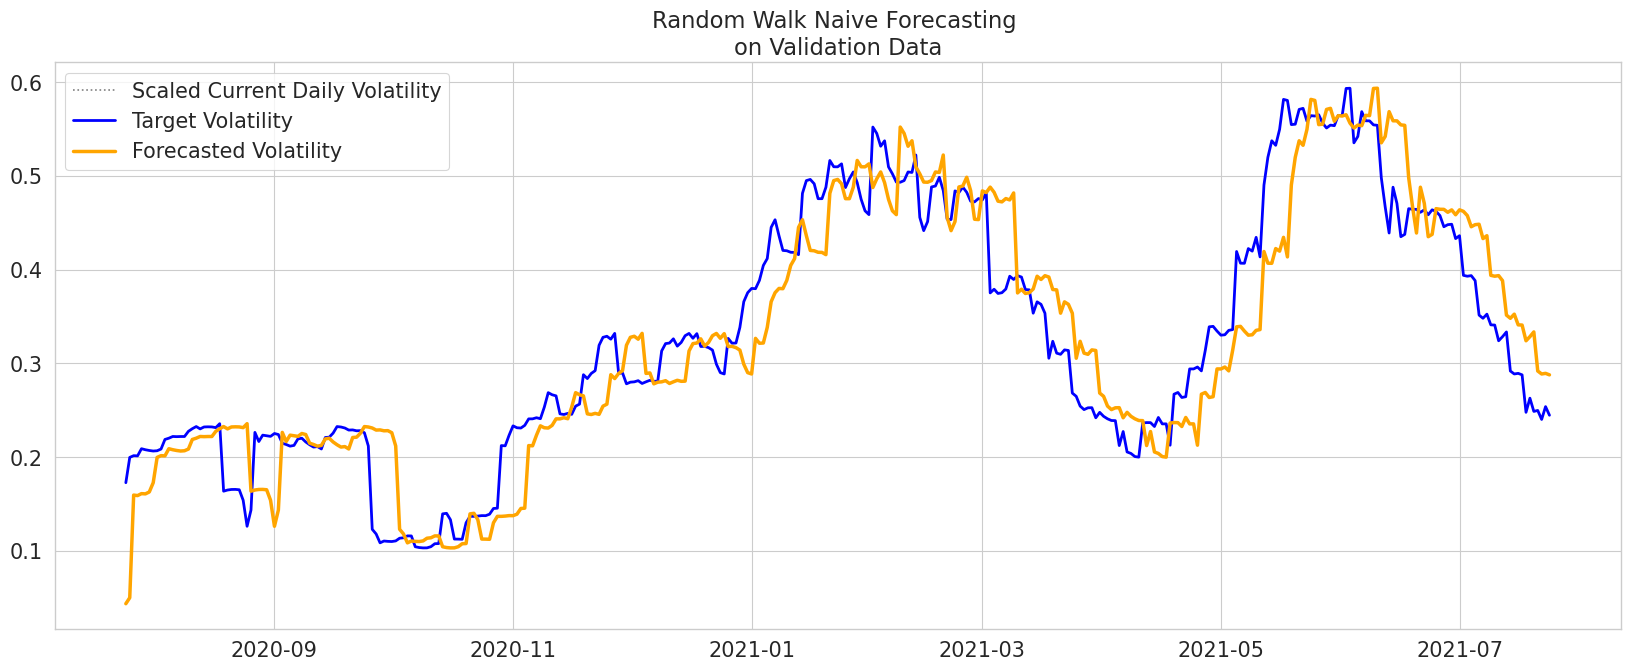

In [66]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, random_walk_preds, 'Random Walk Naive Forecasting')
plt.show();

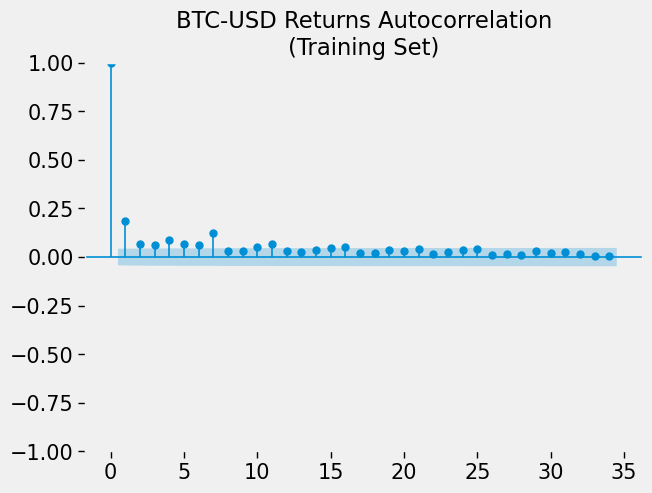

In [68]:
# VISUALIZE AUTOCORRELATION OF SQUARED RETURNS
plot_acf(r_train**2, 
          title=f'{tckr.upper()} Returns Autocorrelation\n(Training Set)');

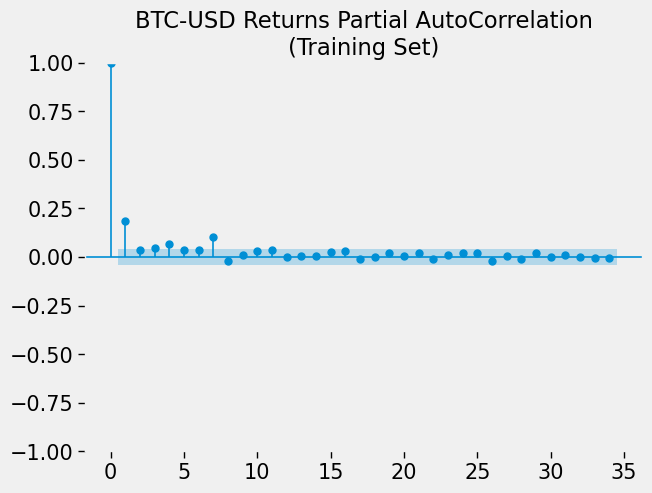

In [69]:
# VISUALIZE PARTIAL AUTOCORRELATION OF SQUARED RETURNS
plot_pacf(r_train**2, 
          title=f'{tckr.upper()} Returns Partial AutoCorrelation\n(Training Set)');

In [70]:
from arch import arch_model

In [71]:
# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

gm_1 = arch_model(r_train, p=7, q=7)
result_1 = gm_1.fit(disp='off')
print()
print(result_1.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5612.30
Distribution:                  Normal   AIC:                           11256.6
Method:            Maximum Likelihood   BIC:                           11347.1
                                        No. Observations:                 2108
Date:                Wed, Jan 11 2023   Df Residuals:                     2107
Time:                        16:28:28   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1787  7.547e-02      2.368  1.789e-02 [3.078e-

In [72]:
gm_1 = arch_model(r_train, vol='GARCH', p=1, q=1)
result_1 = gm_1.fit(disp='off')
print()
print(result_1.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5628.11
Distribution:                  Normal   AIC:                           11264.2
Method:            Maximum Likelihood   BIC:                           11286.8
                                        No. Observations:                 2108
Date:                Wed, Jan 11 2023   Df Residuals:                     2107
Time:                        16:28:41   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1993  6.626e-02      3.007  2.637e-03 [6.939e-

In [73]:
def scale_tf_cond_vol(model_result):
    '''
    Scale & Transform Conditional Volatility 
    Estimated by GARCH Models
    '''
    # OBTAIN ESTIMATED CONDITIONAL VOLATILITY FROM MODEL RESULT
    cond_vol = model_result.conditional_volatility

    # INITIATE SCALER
    scaler = MinMaxScaler()

    # FIT SCALER TO MODEL'S ESTIMATED CONDITIONAL VOLATILITY
    scaler = scaler.fit(cond_vol.values.reshape(-1,1))

    scaled_cond_vol = transform_volatility_to_scaler(scaler, cond_vol)
    return scaler, scaled_cond_vol

In [74]:
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaler_garch, scaled_cond_vol = scale_tf_cond_vol(result_1)

In [75]:
# VISUALIZE MODEL'S ESTIMATED CONDITIONAL VOLATILITY 
# WITH SCALED vol_current CALCULATED ABOVE
def viz_cond_vol(cond_vol_series, model_name):
    with sns.axes_style("darkgrid"):
        fig, ax = plt.subplots(figsize=(18,7))

        ax.plot(x_train_scaled, color='blue', lw=2,
                label=f'Scaled {INTERVAL_WINDOW}-Day Interval Daily Realized Volatility')
        ax.plot(cond_vol_series, color='orange', lw=2,
                label=f'Scaled {model_name} Estimated Conditional Volatility')
        ax.set_title('Training Set')
        plt.legend()
        plt.show();

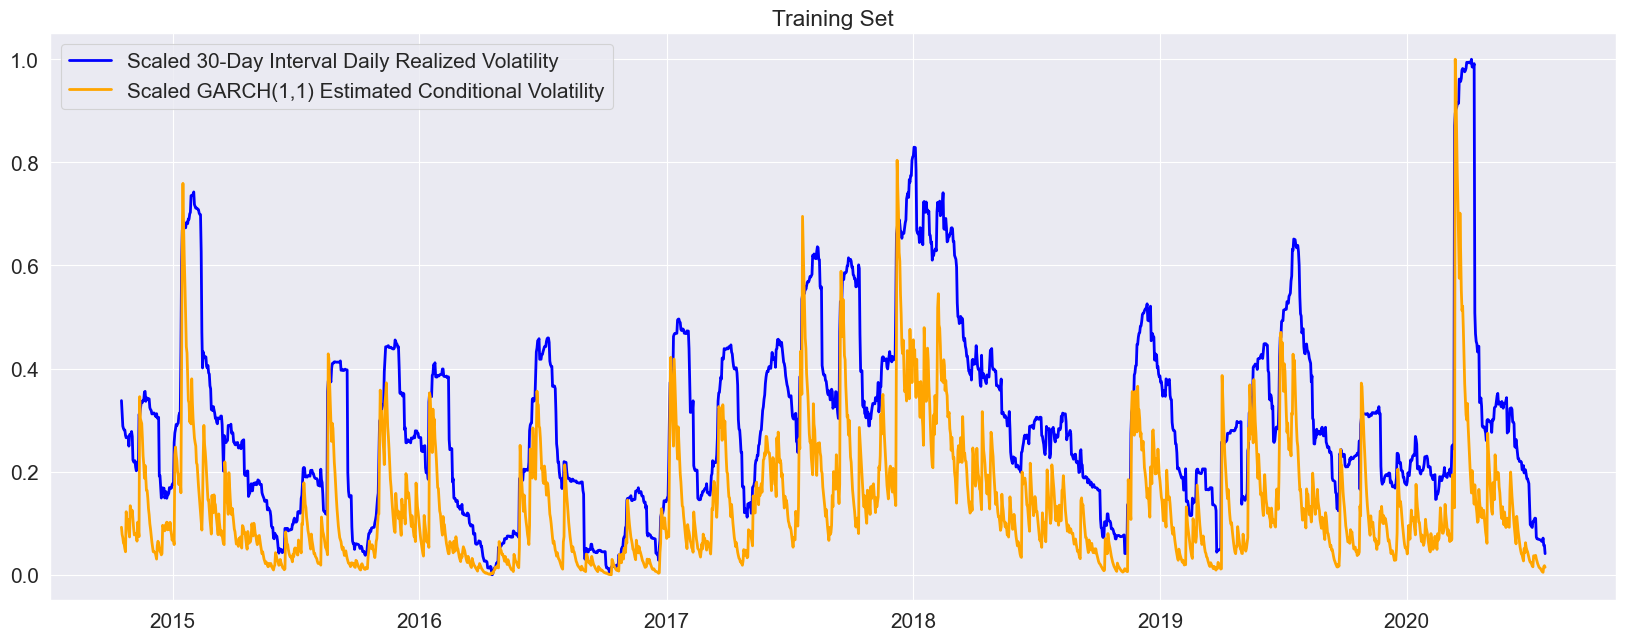

In [76]:
viz_cond_vol(scaled_cond_vol, 'GARCH(1,1)')

In [77]:
# ONE STEP EXPANDING WINDOW FORECAST
# INITIALIZING rolling_forecast
rolling_forecasts = []
idx = df.index

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.returns[:idx]
    
    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, vol='GARCH', p=1, q=1,
                       dist='normal')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    vaR = model_fit.forecast(horizon=n_future, 
                             reindex=False).variance.values
    # GET THE SQRT OF AVERAGE n_future DAYS VARIANCE
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

gm_1_preds = pd.Series(rolling_forecasts, index=val_idx)

In [78]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
gm_1_preds_scaled = transform_volatility_to_scaler(scaler_garch, gm_1_preds)

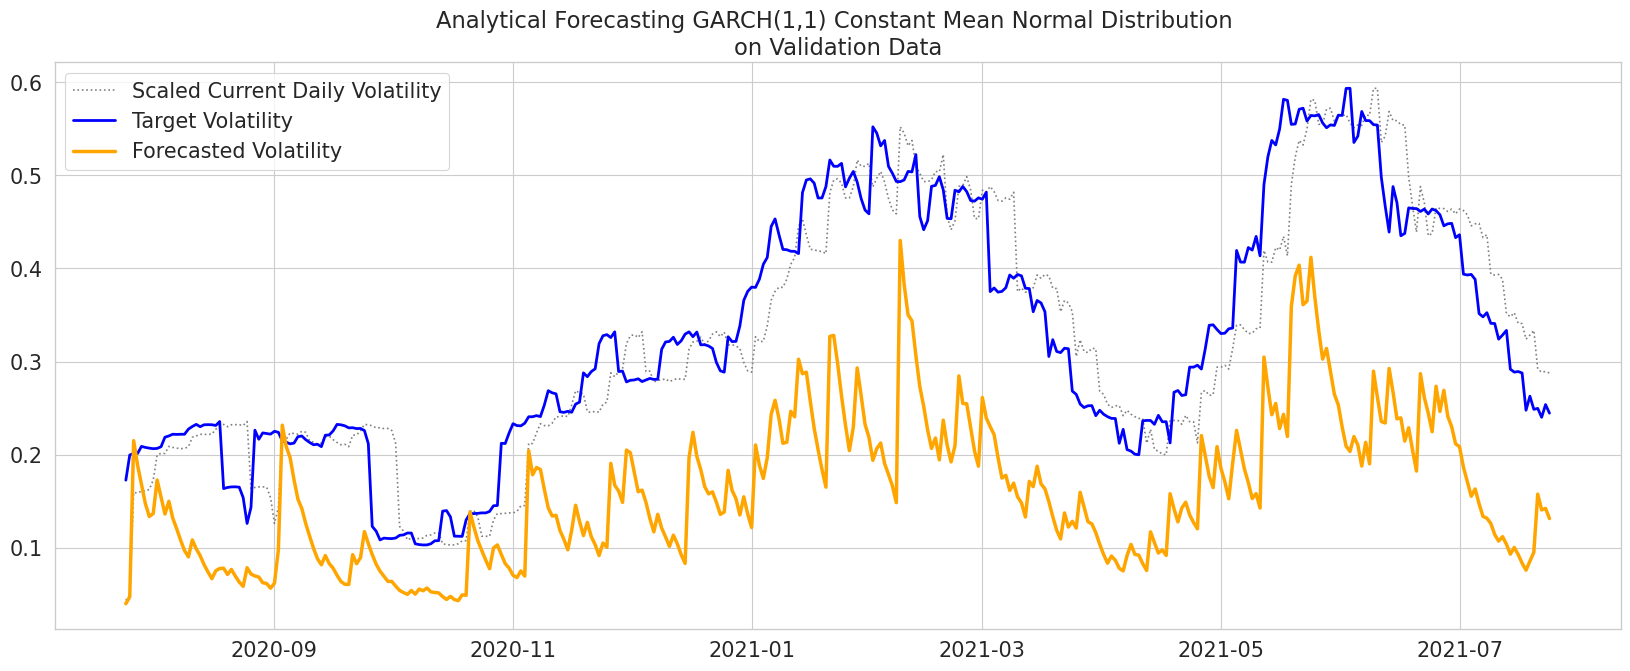

In [79]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, gm_1_preds_scaled, 
          'Analytical Forecasting GARCH(1,1) Constant Mean Normal Distribution')

In [80]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, gm_1_preds_scaled, 
         'GARCH(1,1), Constant Mean, Normal Dist')

Model  Validation RMSPE  Validation RMSE
0                           Mean Baseline          0.559567         0.134522
1           Random Walk Naive Forecasting          0.220522         0.051841
2  GARCH(1,1), Constant Mean, Normal Dist          0.527403         0.184894

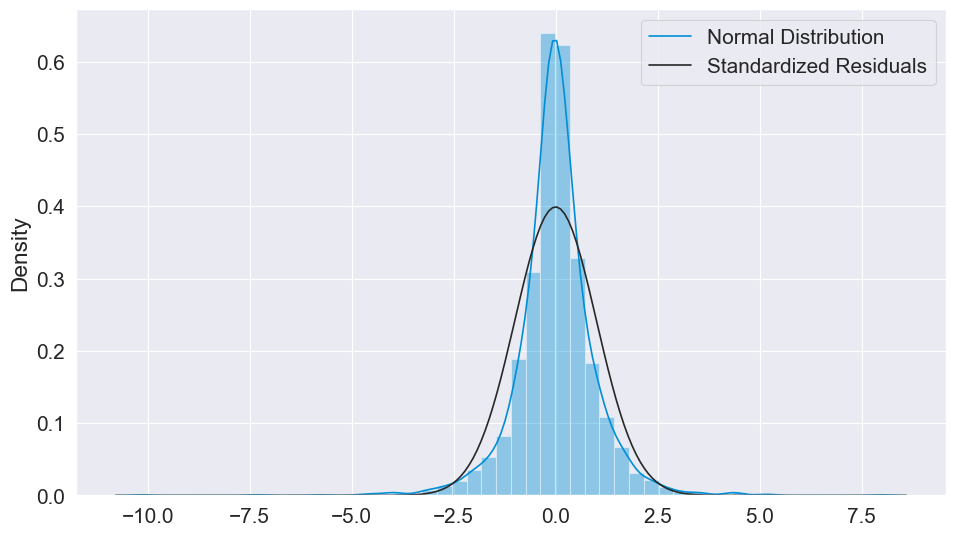

In [81]:
# INSPECTING THE RESIDUALS
gm_resid = result_1.resid
gm_std = result_1.conditional_volatility

# STANDARDIZING RESIDUALS
gm_std_resid = gm_resid / gm_std

# VISUALIZING STANDARDIZED RESIDUALS VS. A NORMAL DISTRIBUTION
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(10,6))
    sns.distplot(gm_std_resid, norm_hist=True, fit=stats.norm, bins=50)
    plt.legend(('Normal Distribution', 'Standardized Residuals'))
    plt.show();

In [82]:
# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

gjr_gm = arch_model(r_train, p=1, q=1, o=1, 
                    vol='GARCH', dist='skewt')
result_2 = gjr_gm.fit(disp='off')
print(result_2.summary())

                         Constant Mean - GJR-GARCH Model Results                         
Dep. Variable:                           returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                             GJR-GARCH   Log-Likelihood:               -5291.01
Distribution:      Standardized Skew Student's t   AIC:                           10596.0
Method:                       Maximum Likelihood   BIC:                           10635.6
                                                   No. Observations:                 2108
Date:                           Wed, Jan 11 2023   Df Residuals:                     2107
Time:                                   18:05:30   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
----------------------------------------

In [83]:
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaler_gjr, scaled_gjr_cond_vol = scale_tf_cond_vol(result_2)

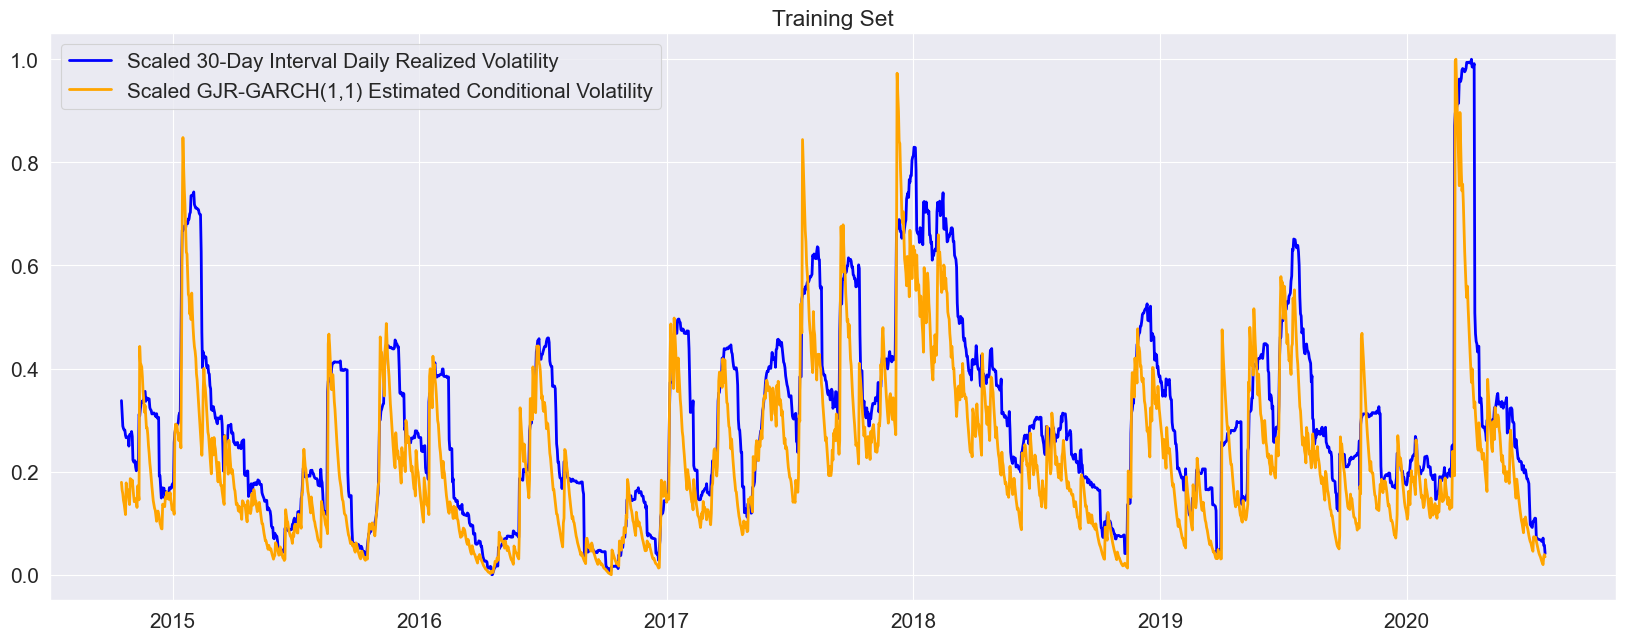

In [84]:
viz_cond_vol(scaled_gjr_cond_vol, 'GJR-GARCH(1,1)')

In [85]:
# ROLLING WINDOW FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.returns[:idx].dropna()

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=1, q=1, o=1, 
                       vol='GARCH', dist='skewt')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    vaR = model_fit.forecast(horizon=n_future, 
                             reindex=False).variance.values
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

gjr_1_preds = pd.DataFrame(rolling_forecasts, index=val_idx)

In [86]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
gjr_1_preds_scaled = transform_volatility_to_scaler(scaler_gjr, gjr_1_preds)

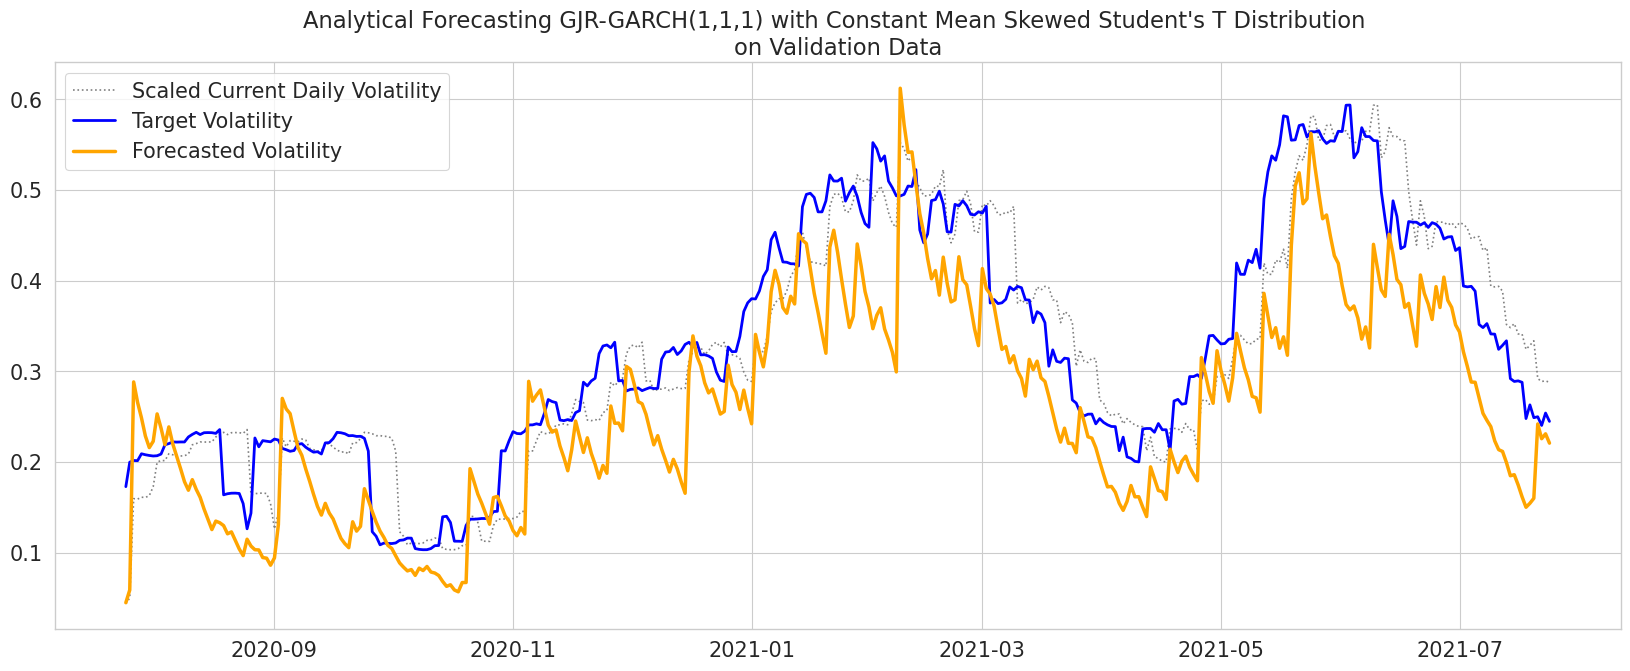

In [87]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, gjr_1_preds_scaled, 
          "Analytical Forecasting GJR-GARCH(1,1,1) with Constant Mean Skewed Student's T Distribution")


In [88]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, gjr_1_preds_scaled, 
         "Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist")

Model  Validation RMSPE  \
0                                           Mean Baseline          0.559567   
1                           Random Walk Naive Forecasting          0.220522   
2                  GARCH(1,1), Constant Mean, Normal Dist          0.527403   
3  Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist          0.270103   

   Validation RMSE  
0         0.134522  
1         0.051841  
2         0.184894  
3         0.088866

In [89]:
# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

t_gm = arch_model(r_train, p=1, o=1, q=1, power=1.0,
                  dist='skewt')
result_3 = t_gm.fit(disp='off')
print(result_3.summary())

                        Constant Mean - TARCH/ZARCH Model Results                        
Dep. Variable:                           returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           TARCH/ZARCH   Log-Likelihood:               -5290.06
Distribution:      Standardized Skew Student's t   AIC:                           10594.1
Method:                       Maximum Likelihood   BIC:                           10633.7
                                                   No. Observations:                 2108
Date:                           Wed, Jan 11 2023   Df Residuals:                     2107
Time:                                   18:07:00   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
----------------------------------------

In [90]:
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaler_tarch, scaled_tarch_cond_vol = scale_tf_cond_vol(result_3)

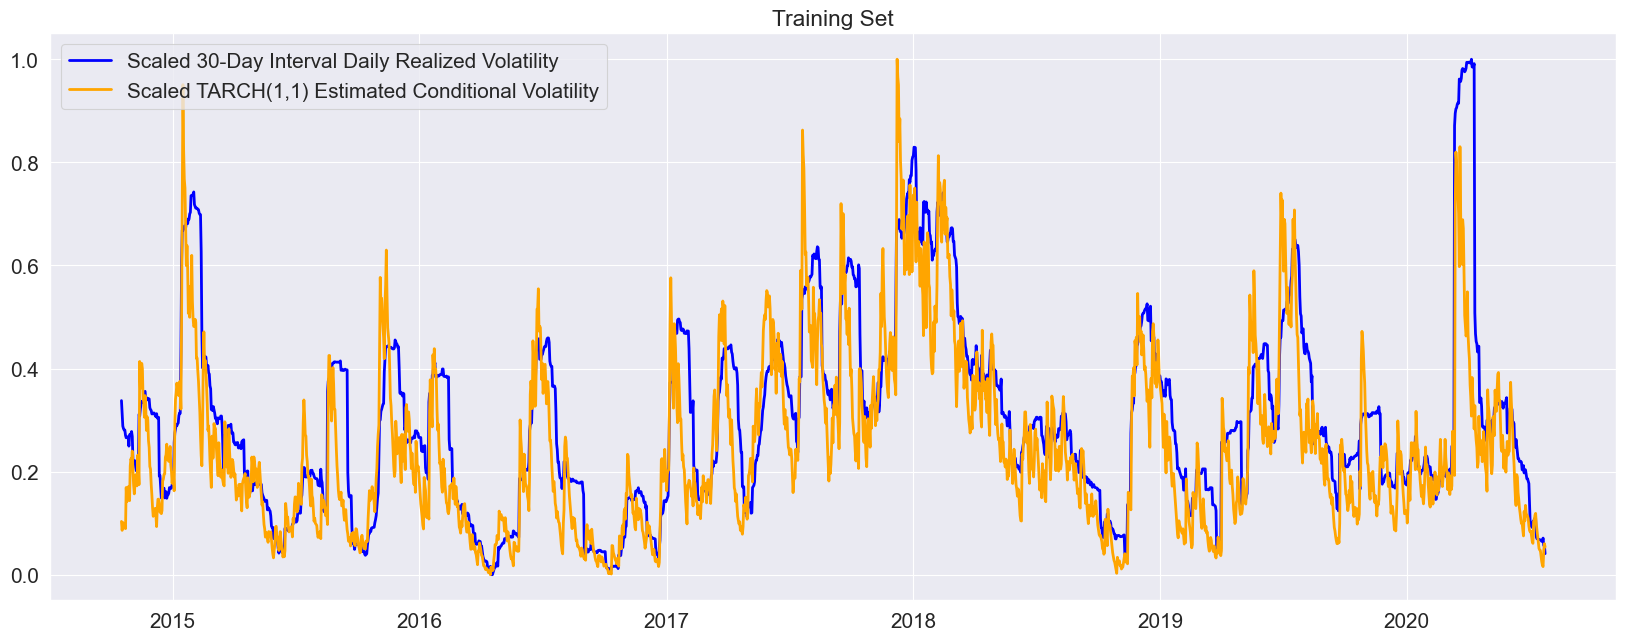

In [91]:
viz_cond_vol(scaled_tarch_cond_vol, 'TARCH(1,1)')

In [94]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
t_bs_preds_scaled = transform_volatility_to_scaler(scaler_tarch, t_bs_preds)

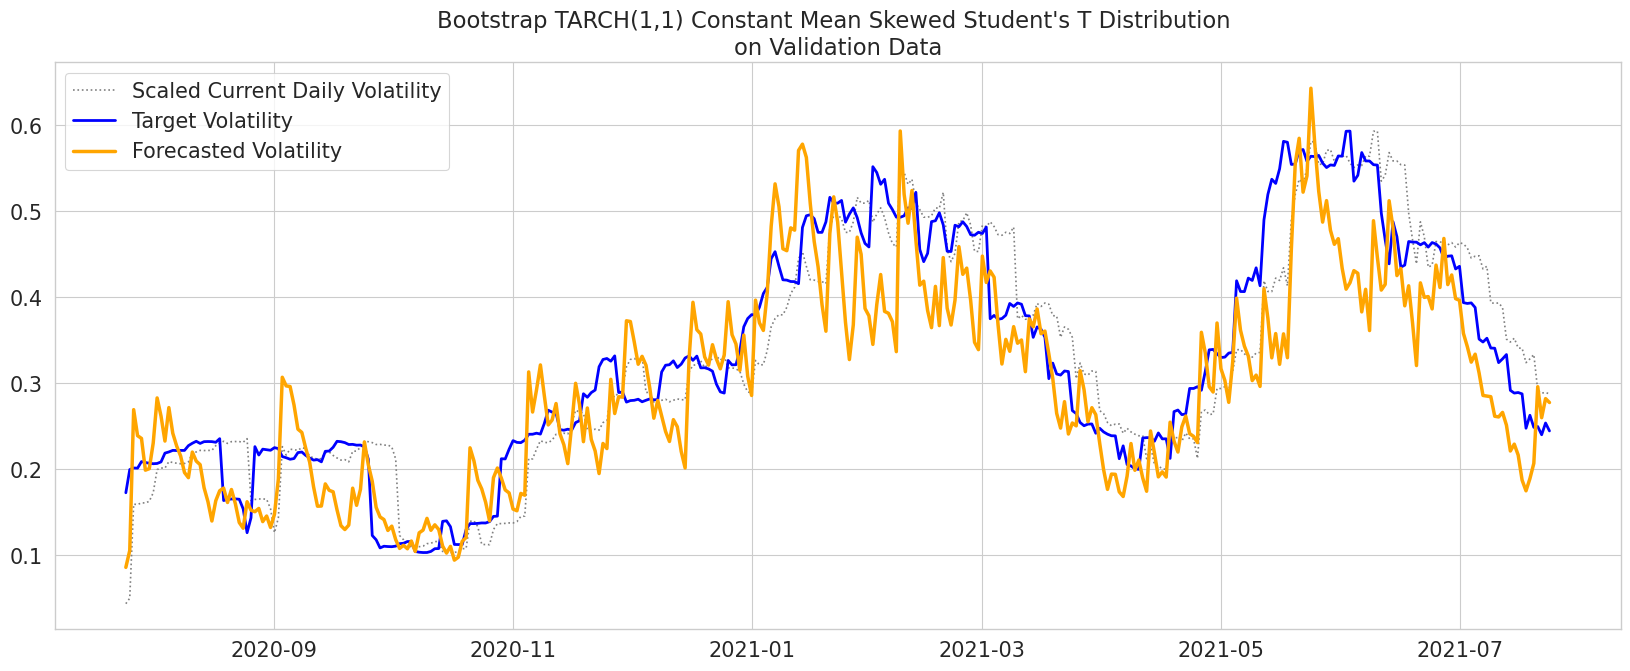

In [95]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, t_bs_preds_scaled, 
          "Bootstrap TARCH(1,1) Constant Mean Skewed Student's T Distribution")

In [96]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, t_bs_preds_scaled, 
         "Bootstrap TARCH(1,1), Constant Mean, Skewt Dist")

Model  Validation RMSPE  \
0                                           Mean Baseline          0.559567   
1                           Random Walk Naive Forecasting          0.220522   
2                  GARCH(1,1), Constant Mean, Normal Dist          0.527403   
3  Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist          0.270103   
4         Bootstrap TARCH(1,1), Constant Mean, Skewt Dist          0.206109   

   Validation RMSE  
0         0.134522  
1         0.051841  
2         0.184894  
3         0.088866  
4         0.069363

In [ ]:
t_sm_preds = pd.DataFrame(rolling_forecasts, index=val_idx)

In [101]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
t_sm_preds_scaled = transform_volatility_to_scaler(scaler_tarch, t_sm_preds)

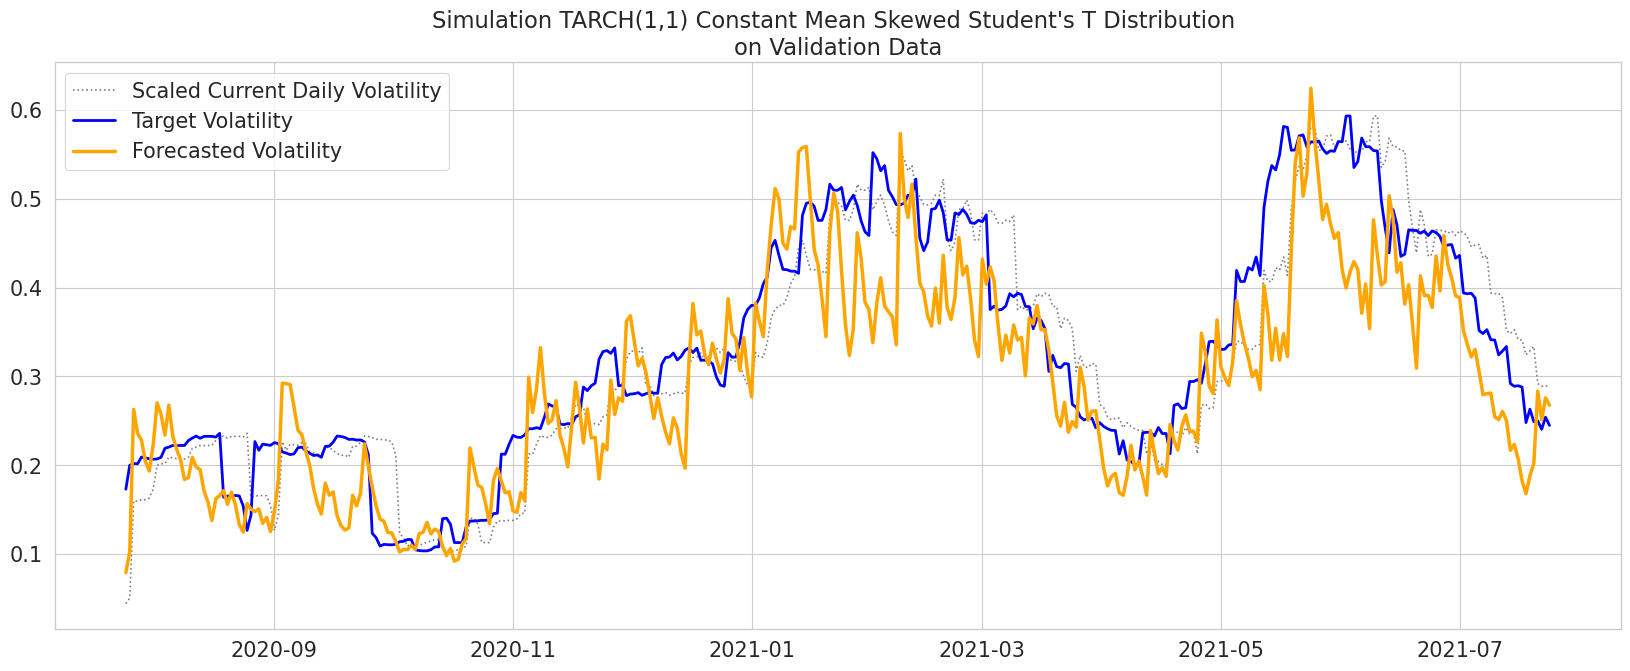

In [102]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, t_sm_preds_scaled, 
          "Simulation TARCH(1,1) Constant Mean Skewed Student's T Distribution")

In [104]:
#APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, t_sm_preds_scaled, 
         "Simulation TARCH(1,1), Constant Mean, Skewt Dist")

Model  Validation RMSPE  \
0                                           Mean Baseline          0.559567   
1                           Random Walk Naive Forecasting          0.220522   
2                  GARCH(1,1), Constant Mean, Normal Dist          0.527403   
3  Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist          0.270103   
4         Bootstrap TARCH(1,1), Constant Mean, Skewt Dist          0.206109   
5        Simulation TARCH(1,1), Constant Mean, Skewt Dist          0.209509   

   Validation RMSE  
0         0.134522  
1         0.051841  
2         0.184894  
3         0.088866  
4         0.069363  
5         0.072540